# Imports

In [5]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import catboost as cb

# turn off warnings 
import warnings
warnings.filterwarnings("ignore")

# Functions

In [10]:
def detect_outlier(df, col):
    Q1= df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_index = df.index[ (df[col] < lower_bound) | (df[col] > upper_bound)]
    lower_outliers_index = df.index[ (df[col] < lower_bound)]
    upper_outliers_index = df.index[ (df[col] > upper_bound)]
    
    return outliers_index, lower_outliers_index, upper_outliers_index


def remove_outlier(df , ls):
    ls = sorted(set(ls))
    clean_df= df.drop(ls)
    
    return clean_df

# Raw Data

In [6]:
raw_data = pd.read_csv('newyork_housing.csv')
raw_data.shape

(75630, 1507)

# Data Prep

In [7]:
# getting rid of columns that contain photos
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='photos')))]

# getting rid of columns that priceHistory
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='priceHistory')))]

# getting rid of columns >> accessibilityFeatures : It's all NULL 
raw_data = raw_data[raw_data.columns.drop(list(raw_data.filter(regex='accessibilityFeatures')))]


# drop NULL values for on market date : we need to know which ones have a date 
raw_data = raw_data.dropna(subset = ['resoFactsStats/onMarketDate'])

# Only keep sold or recently sold properties 
raw_data = raw_data[(raw_data['homeStatus'] == 'SOLD') | (raw_data['homeStatus'] == 'RECENTLY_SOLD')]

#To clean lot size and unify units: replace comma, extract only numbers from col
raw_data['resoFactsStats/lotSize']= raw_data['resoFactsStats/lotSize'].str.replace(',','')
#split by space
raw_data[['lotsize','unit']] = raw_data["resoFactsStats/lotSize"].str.split(" ", 1, expand=True)
#convert string to float
raw_data['lotsize']=raw_data['lotsize'].astype(float)
# convert acre to sqft
raw_data['lot_size_sqf'] = raw_data['lotsize'].apply(lambda x: x * 43560 if x < 100 else x)


#replace comma, extract only numbers from col , and replace Nan with 0 for hoa
raw_data['resoFactsStats/associationFee']= raw_data['resoFactsStats/associationFee'].str.replace(',','')
raw_data['resoFactsStats/associationFee']= raw_data['resoFactsStats/associationFee'].str.extract('(\d+)')
raw_data['hoa']=raw_data['resoFactsStats/associationFee'].fillna(0)


# Convert the weird data format and only keep properties after 2020-05 based on their distribution plot
raw_data['y-m'] =raw_data['resoFactsStats/onMarketDate'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m'))
#raw_data['y-m'].value_counts().sort_index(ascending = True).plot()#raw_data['y-m'].value_counts().sort_index(ascending = True).plot()
#raw_data['y-m'].value_counts().sort_index(ascending = False)

#replace NaN with 0 
raw_data['resoFactsStats/hasFireplace'].fillna(0, inplace = True)

#replace NaN first with '0', then create another column that is binary and shows if a property have basement or not 
raw_data['resoFactsStats/basement'].fillna('0', inplace = True)
raw_data['basement'] = raw_data['resoFactsStats/basement'].apply(lambda x: 0 if x == 'None' or x== '0' else 1)


# convert to rigth data types
raw_data=raw_data.astype({'hoa': 'float'})
raw_data=raw_data.astype({'resoFactsStats/hasFireplace': 'float'})

## Extracting timefarme with the highest ferquency
df= raw_data[raw_data['y-m']>='2020-05']


want_cols= ['bathrooms', 
            'bedrooms', 
            'yearBuilt', 
            'propertyTaxRate',
            'livingArea',
            'lot_size_sqf',
            'schools/0/rating',
            'hoa',
            'resoFactsStats/garageSpaces',
            'resoFactsStats/hasFireplace',
            'basement',
            'latitude',
            'longitude',
            'price'
            ]

df = df[want_cols]
df.rename({
            #'resoFactsStats/hasGarage' : 'hasGarage', garage spaces have the same impact, maybe even better
            'resoFactsStats/garageSpaces' : 'garageSpaces',
            'resoFactsStats/hasFireplace' : 'hasFireplace',
            'propertyTaxRate' : 'propTax',
            'schools/0/rating': 'schlRnk',
              }, axis=1, inplace=True)

# Removing outliers

In [11]:
# take out price outliers
outliers_index, lower_index, upper_index = detect_outlier(df, 'price')
#remove lower bound
clean_df= remove_outlier(df, lower_index.tolist())
# remove prices over 2M
clean_df = clean_df[clean_df['price'] <= 2000000]

#remove outlier of garageSpaces
clean_df = clean_df[clean_df['garageSpaces'] <= 6]

#take out lot_sie_sqf outlier out
clean_df=clean_df[clean_df['lot_size_sqf']<=10000]

#take out outlier
clean_df=clean_df[clean_df['bedrooms']<10]

# eliminate hoa outliers
clean_df= clean_df[clean_df['hoa']<=2000]

<AxesSubplot:xlabel='price', ylabel='Count'>

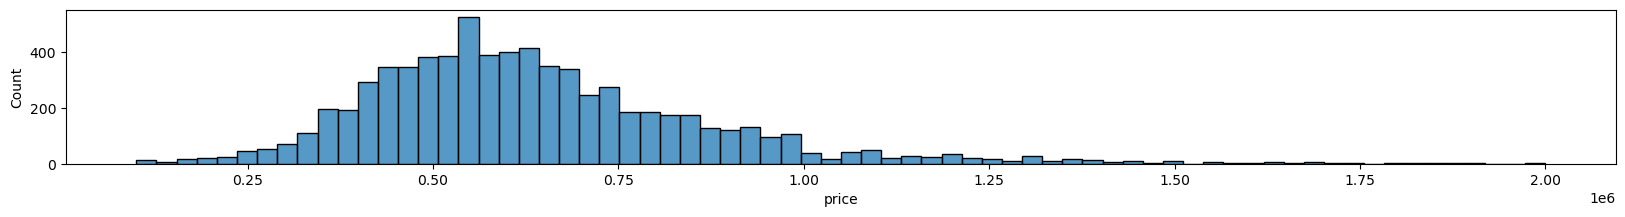

In [162]:
fig, ax =plt.subplots(figsize=(20,2))
sn.histplot(x = clean_df['price'] )

# right skewed 
sn.histplot(clean_df[clean_df['lot_size_sqf']<10000].lot_size_sqf)

# right skewed
sn.histplot(clean_df['latitude'])

# right skewed
sn.histplot(clean_df['longitude'])

# right skewed
sn.histplot(clean_df['bathrooms'])

# right skewed
sn.set(rc={"figure.figsize":(6, 4)})
sn.histplot(clean_df['bedrooms'])

sn.scatterplot(x= 'basement_',
                    y="bathrooms",
                    data= clean_df)

# meh
sn.set(rc={"figure.figsize":(6, 4)})
sn.histplot(clean_df['yearBuilt'])

# meh
sn.histplot(clean_df['propTax'])

# good
sn.histplot(clean_df['schlRnk'])

# right skewed >> better to keep under 1000 or 2000; or give them the max of hoa we want to keep: so we don't drop too much
sn.histplot(clean_df['hoa'])

# right skewed
sn.histplot(clean_df['garageSpaces'])

# right skewed
sn.histplot(clean_df['hasFireplace'])

# good
sn.histplot(clean_df['basement'])

# LivingArea vs. Price
sn.scatterplot(x= 'livingArea',
                    y="price",
                    data= clean_df)

In [193]:
import matplotlib.pyplot as plt
# Define the number of rows and columns you want
sn.set(rc={"figure.figsize":(16, 20)})
#plt.figure(figsize=(10,20))
n_rows=17
n_cols=1
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

for i, column in enumerate(clean_df.columns):
    sn.histplot(df[column],ax=axes[i])

Error in callback <function flush_figures at 0x000001EF35936940> (for post_execute):


KeyboardInterrupt: 

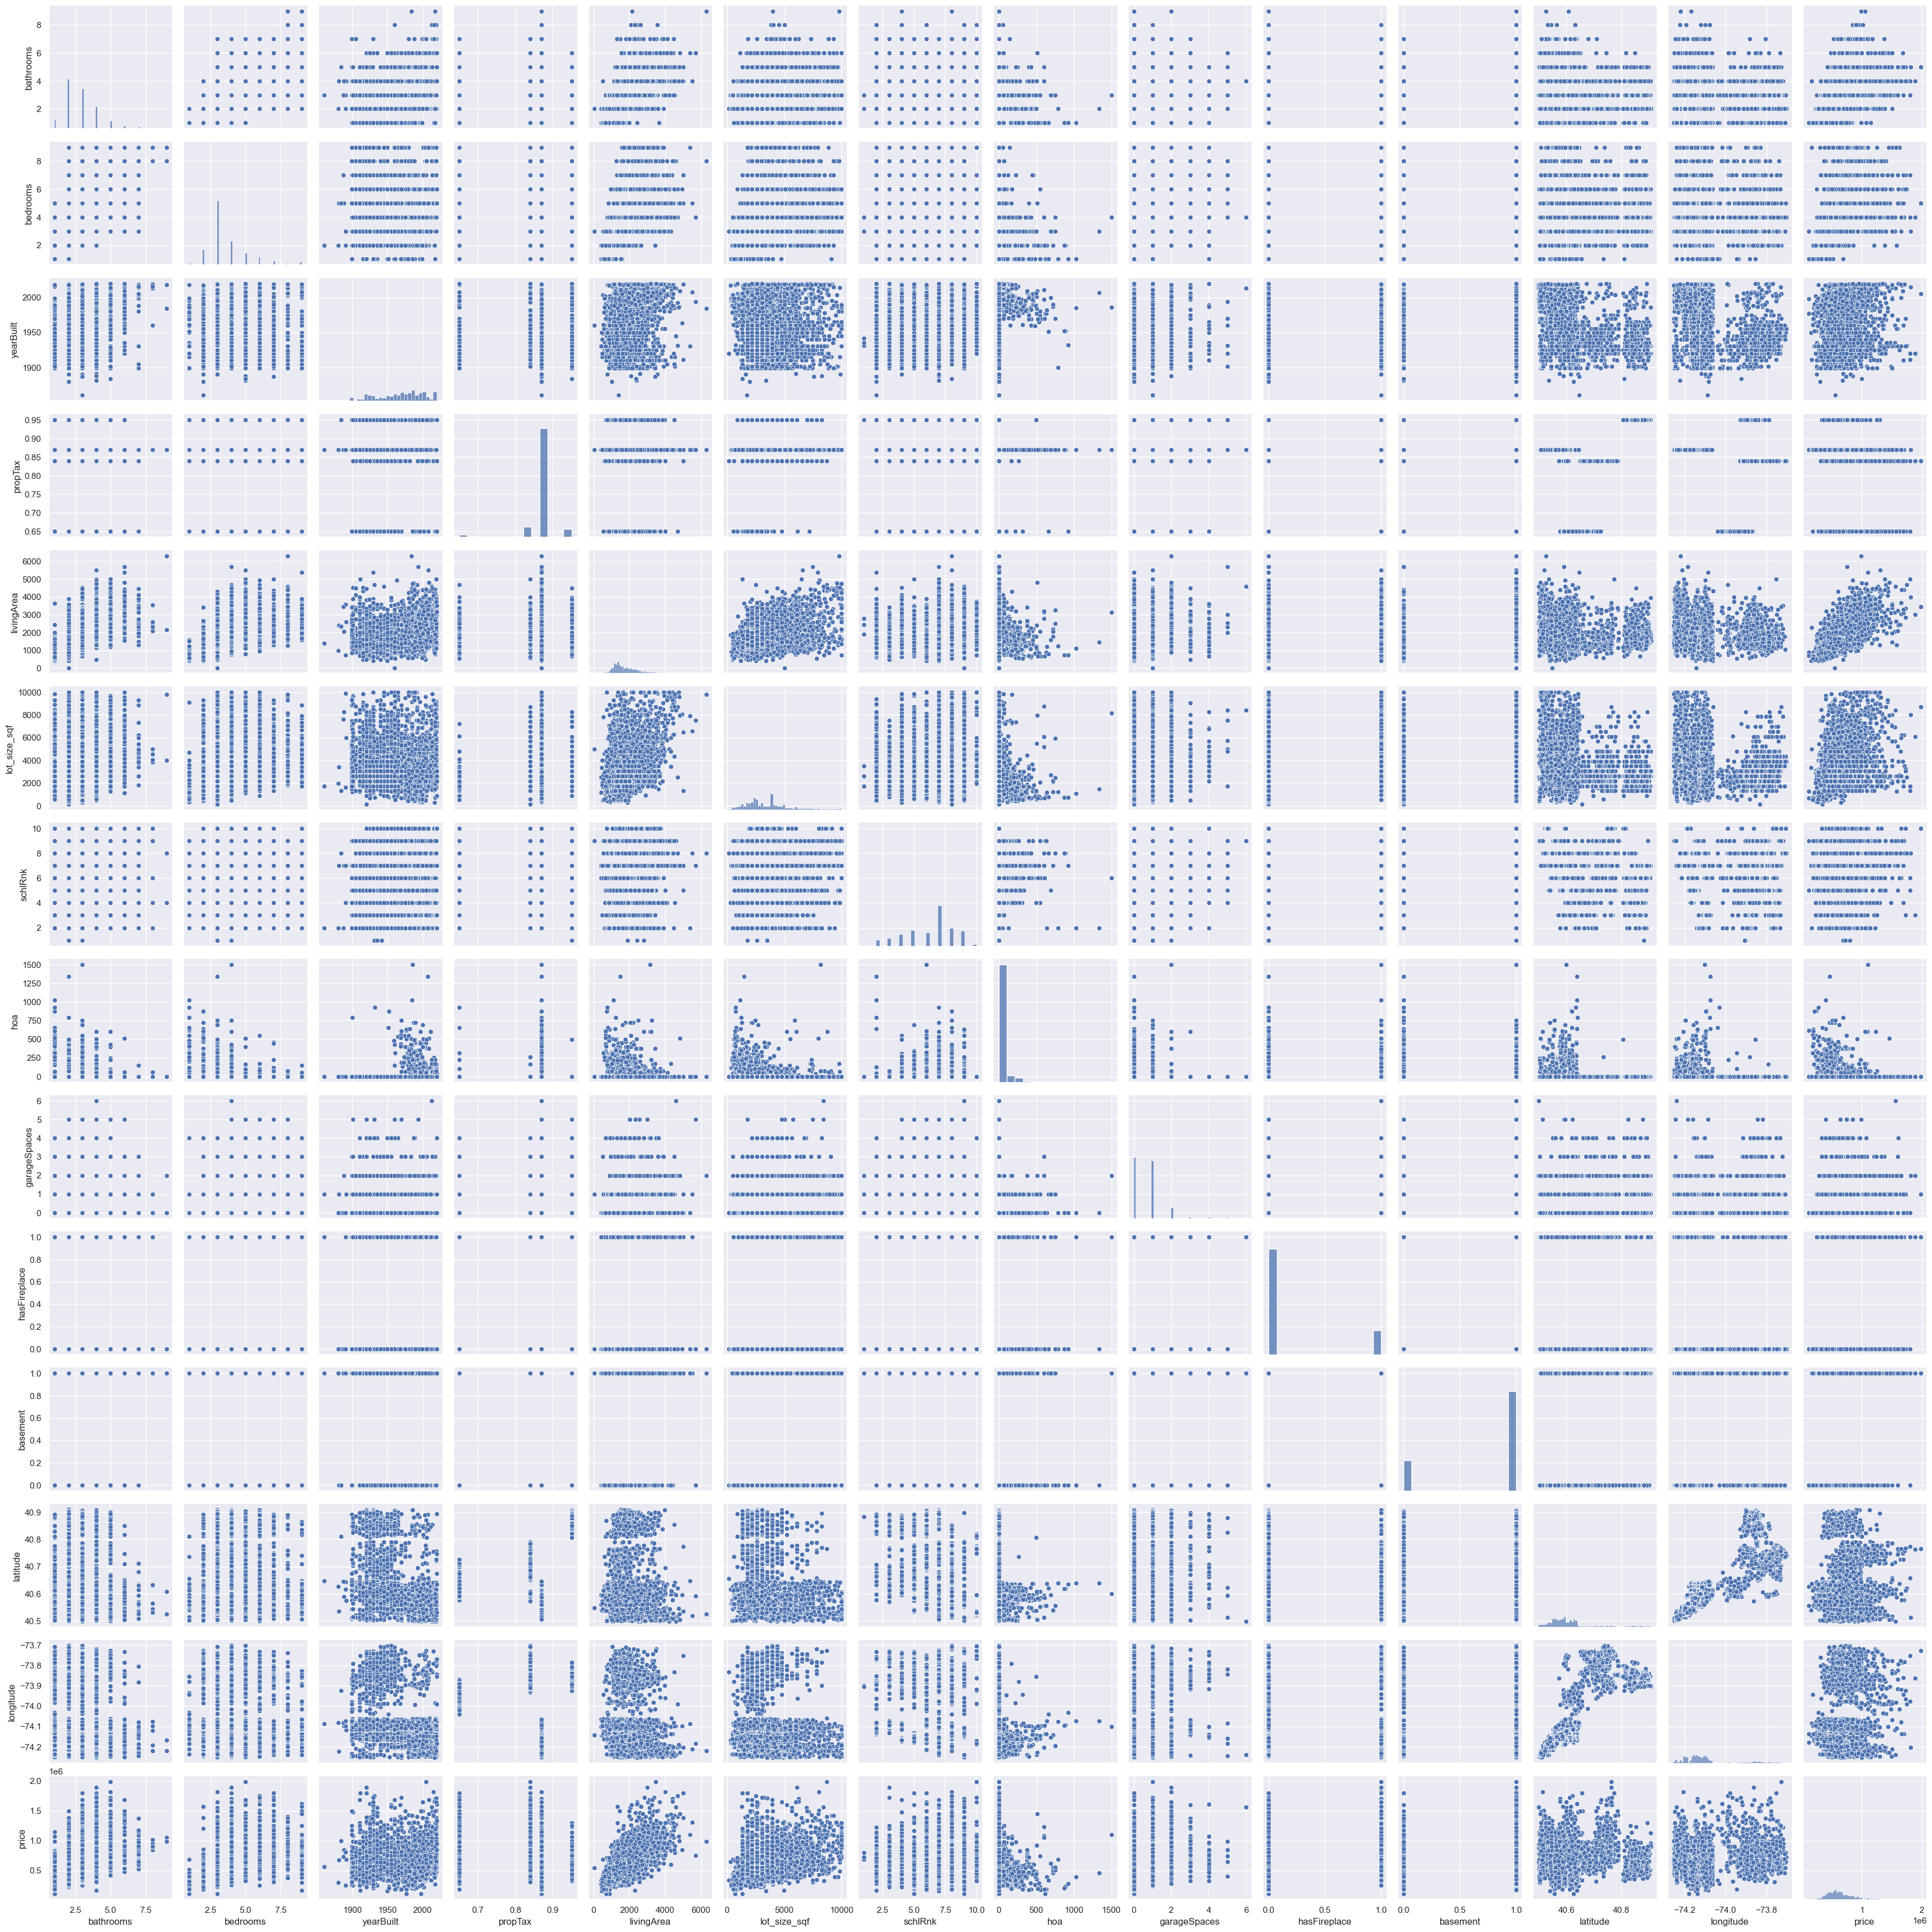

In [200]:
sn.pairplot(clean_df)

In [207]:
for i in clean_df.columns:
    print(i,' NULL %= ', (clean_df[i].isnull().sum() * 100) / 6711)

bathrooms  NULL %=  0.05960363582178513
bedrooms  NULL %=  0.0
yearBuilt  NULL %=  0.10430636268812397
propTax  NULL %=  0.014900908955446282
livingArea  NULL %=  5.304723588138876
lot_size_sqf  NULL %=  0.0
schlRnk  NULL %=  0.32781999701981823
hoa  NULL %=  0.0
garageSpaces  NULL %=  0.0
hasFireplace  NULL %=  0.0
basement  NULL %=  0.0
latitude  NULL %=  0.0
longitude  NULL %=  0.0
price  NULL %=  0.0


# X and y

In [12]:
#clean_df.head()
X = clean_df.iloc[:,:-1]
y = clean_df['price']

# train set and remaining set:
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size = 0.2, random_state=5)

# Splitting remaining set to test set and validation set(houdout)
X_test, X_valid, y_test, y_valid = train_test_split(X_remain, y_remain, test_size = 0.5, random_state=5)

y.shape, X.shape, X_train.shape, X_test.shape, X_valid.shape

((6711,), (6711, 13), (5368, 13), (671, 13), (672, 13))

## Catboost Model

In [13]:
model_c = cb.CatBoostRegressor(loss_function='RMSE') #try R2 as well

model_c.fit(X_train, y_train, plot= True, eval_set=(X_valid, y_valid), verbose = False )
#epochs maybe 200


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
#cv_16_results = cross_val_score(model_c, X_train, y_train, cv=16, verbose= True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.052851
0:	learn: 210740.0625995	total: 2.67ms	remaining: 2.67s
1:	learn: 204273.2982204	total: 4.76ms	remaining: 2.38s
2:	learn: 198210.1854473	total: 6.94ms	remaining: 2.31s
3:	learn: 192755.5096212	total: 9.2ms	remaining: 2.29s
4:	learn: 187545.4045692	total: 11.4ms	remaining: 2.27s
5:	learn: 182726.9574848	total: 13.7ms	remaining: 2.27s
6:	learn: 178258.1014888	total: 16.2ms	remaining: 2.3s
7:	learn: 174241.6889460	total: 18.4ms	remaining: 2.28s
8:	learn: 170303.0375186	total: 20.6ms	remaining: 2.27s
9:	learn: 166597.3375476	total: 22.7ms	remaining: 2.25s
10:	learn: 162874.2411660	total: 24.7ms	remaining: 2.22s
11:	learn: 159218.3380825	total: 27.1ms	remaining: 2.23s
12:	learn: 156015.7851537	total: 29.3ms	remaining: 2.22s
13:	learn: 152867.8186658	total: 31.2ms	remaining: 2.2s
14:	learn: 150006.4285282	total: 33.7ms	remaining: 2.21s
15:	learn: 147154.7770787	total: 35.8ms	remaining: 2.2s
16:	learn: 144626.8162833	total: 38.4ms	remaining: 2.22s
17:	learn: 1422

191:	learn: 79932.9342623	total: 400ms	remaining: 1.68s
192:	learn: 79851.7451873	total: 402ms	remaining: 1.68s
193:	learn: 79748.5021542	total: 404ms	remaining: 1.68s
194:	learn: 79667.6543556	total: 406ms	remaining: 1.68s
195:	learn: 79626.8126060	total: 408ms	remaining: 1.67s
196:	learn: 79526.5986341	total: 410ms	remaining: 1.67s
197:	learn: 79429.8832262	total: 413ms	remaining: 1.67s
198:	learn: 79375.4184280	total: 415ms	remaining: 1.67s
199:	learn: 79279.4601579	total: 418ms	remaining: 1.67s
200:	learn: 79187.5071368	total: 420ms	remaining: 1.67s
201:	learn: 79109.7456320	total: 422ms	remaining: 1.67s
202:	learn: 79035.4862921	total: 424ms	remaining: 1.66s
203:	learn: 78964.1099272	total: 426ms	remaining: 1.66s
204:	learn: 78894.5167967	total: 427ms	remaining: 1.66s
205:	learn: 78799.6745216	total: 430ms	remaining: 1.66s
206:	learn: 78694.2965626	total: 432ms	remaining: 1.65s
207:	learn: 78616.2062822	total: 434ms	remaining: 1.65s
208:	learn: 78565.8125783	total: 436ms	remaining

373:	learn: 69341.3028578	total: 786ms	remaining: 1.31s
374:	learn: 69306.2607159	total: 788ms	remaining: 1.31s
375:	learn: 69241.1157908	total: 790ms	remaining: 1.31s
376:	learn: 69194.7317184	total: 792ms	remaining: 1.31s
377:	learn: 69151.3080622	total: 794ms	remaining: 1.31s
378:	learn: 69125.0818685	total: 796ms	remaining: 1.3s
379:	learn: 69099.7232332	total: 798ms	remaining: 1.3s
380:	learn: 69035.6154354	total: 801ms	remaining: 1.3s
381:	learn: 68987.8235975	total: 803ms	remaining: 1.3s
382:	learn: 68946.8014879	total: 805ms	remaining: 1.3s
383:	learn: 68926.0562975	total: 807ms	remaining: 1.29s
384:	learn: 68851.9313451	total: 809ms	remaining: 1.29s
385:	learn: 68823.3549529	total: 812ms	remaining: 1.29s
386:	learn: 68785.5116549	total: 813ms	remaining: 1.29s
387:	learn: 68720.1283382	total: 815ms	remaining: 1.29s
388:	learn: 68659.1289654	total: 817ms	remaining: 1.28s
389:	learn: 68611.4272696	total: 819ms	remaining: 1.28s
390:	learn: 68589.1988177	total: 821ms	remaining: 1.2

539:	learn: 63572.8400434	total: 1.18s	remaining: 1s
540:	learn: 63560.0759452	total: 1.18s	remaining: 1s
541:	learn: 63536.7678874	total: 1.19s	remaining: 1s
542:	learn: 63509.1024748	total: 1.19s	remaining: 1000ms
543:	learn: 63478.6052188	total: 1.19s	remaining: 998ms
544:	learn: 63451.8183250	total: 1.19s	remaining: 996ms
545:	learn: 63401.8817655	total: 1.2s	remaining: 995ms
546:	learn: 63380.7032695	total: 1.2s	remaining: 993ms
547:	learn: 63378.0650274	total: 1.2s	remaining: 991ms
548:	learn: 63353.8601227	total: 1.2s	remaining: 990ms
549:	learn: 63311.7114852	total: 1.21s	remaining: 988ms
550:	learn: 63277.2224470	total: 1.21s	remaining: 986ms
551:	learn: 63247.0863091	total: 1.21s	remaining: 985ms
552:	learn: 63208.0595896	total: 1.22s	remaining: 983ms
553:	learn: 63190.7573580	total: 1.22s	remaining: 981ms
554:	learn: 63156.9559374	total: 1.22s	remaining: 980ms
555:	learn: 63117.9430983	total: 1.22s	remaining: 978ms
556:	learn: 63076.9641927	total: 1.23s	remaining: 975ms
557:

687:	learn: 59627.0160682	total: 1.57s	remaining: 711ms
688:	learn: 59597.5116666	total: 1.57s	remaining: 709ms
689:	learn: 59577.1385146	total: 1.57s	remaining: 707ms
690:	learn: 59560.2201968	total: 1.57s	remaining: 704ms
691:	learn: 59524.9785246	total: 1.58s	remaining: 702ms
692:	learn: 59501.8380227	total: 1.58s	remaining: 699ms
693:	learn: 59477.0960012	total: 1.58s	remaining: 697ms
694:	learn: 59451.7698561	total: 1.58s	remaining: 695ms
695:	learn: 59439.7425243	total: 1.58s	remaining: 692ms
696:	learn: 59429.3441621	total: 1.59s	remaining: 690ms
697:	learn: 59428.3925708	total: 1.59s	remaining: 687ms
698:	learn: 59394.6689788	total: 1.59s	remaining: 685ms
699:	learn: 59373.6806766	total: 1.59s	remaining: 683ms
700:	learn: 59340.6144065	total: 1.6s	remaining: 681ms
701:	learn: 59300.8895660	total: 1.6s	remaining: 679ms
702:	learn: 59273.5397433	total: 1.6s	remaining: 676ms
703:	learn: 59242.5921580	total: 1.6s	remaining: 674ms
704:	learn: 59196.9277309	total: 1.6s	remaining: 672

881:	learn: 55318.6740887	total: 1.97s	remaining: 263ms
882:	learn: 55287.7982527	total: 1.97s	remaining: 261ms
883:	learn: 55273.2554092	total: 1.97s	remaining: 258ms
884:	learn: 55254.8900684	total: 1.97s	remaining: 256ms
885:	learn: 55253.3106772	total: 1.97s	remaining: 254ms
886:	learn: 55243.5733737	total: 1.98s	remaining: 252ms
887:	learn: 55219.3736045	total: 1.98s	remaining: 249ms
888:	learn: 55192.1284902	total: 1.98s	remaining: 247ms
889:	learn: 55157.8871548	total: 1.98s	remaining: 245ms
890:	learn: 55137.4112267	total: 1.98s	remaining: 243ms
891:	learn: 55124.7502453	total: 1.99s	remaining: 240ms
892:	learn: 55098.7914675	total: 1.99s	remaining: 238ms
893:	learn: 55075.6722768	total: 1.99s	remaining: 236ms
894:	learn: 55061.5120731	total: 1.99s	remaining: 234ms
895:	learn: 55046.5672298	total: 1.99s	remaining: 232ms
896:	learn: 55010.9995820	total: 2s	remaining: 229ms
897:	learn: 54996.5077912	total: 2s	remaining: 227ms
898:	learn: 54988.7253164	total: 2s	remaining: 225ms
8

41:	learn: 108634.4149941	total: 92.6ms	remaining: 2.11s
42:	learn: 107948.7414198	total: 95ms	remaining: 2.11s
43:	learn: 107197.3504367	total: 97.2ms	remaining: 2.11s
44:	learn: 106551.0034512	total: 99.5ms	remaining: 2.11s
45:	learn: 105979.0104499	total: 102ms	remaining: 2.11s
46:	learn: 105215.4141679	total: 104ms	remaining: 2.12s
47:	learn: 104606.1904897	total: 107ms	remaining: 2.12s
48:	learn: 103988.1228485	total: 109ms	remaining: 2.11s
49:	learn: 103517.9038735	total: 111ms	remaining: 2.11s
50:	learn: 102891.2457498	total: 113ms	remaining: 2.11s
51:	learn: 102423.7687116	total: 116ms	remaining: 2.11s
52:	learn: 101849.9846490	total: 118ms	remaining: 2.1s
53:	learn: 101418.7359132	total: 121ms	remaining: 2.11s
54:	learn: 100916.6806900	total: 123ms	remaining: 2.12s
55:	learn: 100368.7274247	total: 125ms	remaining: 2.11s
56:	learn: 99955.6273132	total: 128ms	remaining: 2.11s
57:	learn: 99598.4114708	total: 130ms	remaining: 2.11s
58:	learn: 99137.2689881	total: 132ms	remaining: 

228:	learn: 75974.2972097	total: 491ms	remaining: 1.65s
229:	learn: 75895.6535745	total: 493ms	remaining: 1.65s
230:	learn: 75844.8198214	total: 495ms	remaining: 1.65s
231:	learn: 75767.8680277	total: 497ms	remaining: 1.65s
232:	learn: 75701.0002916	total: 499ms	remaining: 1.64s
233:	learn: 75622.0247775	total: 501ms	remaining: 1.64s
234:	learn: 75533.9912504	total: 503ms	remaining: 1.64s
235:	learn: 75458.6639946	total: 506ms	remaining: 1.64s
236:	learn: 75398.7532611	total: 508ms	remaining: 1.63s
237:	learn: 75329.5865977	total: 510ms	remaining: 1.63s
238:	learn: 75261.8594910	total: 512ms	remaining: 1.63s
239:	learn: 75203.6209281	total: 514ms	remaining: 1.63s
240:	learn: 75192.2687318	total: 516ms	remaining: 1.62s
241:	learn: 75127.5884391	total: 518ms	remaining: 1.62s
242:	learn: 75064.3441910	total: 520ms	remaining: 1.62s
243:	learn: 75030.8680181	total: 522ms	remaining: 1.62s
244:	learn: 75025.1080039	total: 523ms	remaining: 1.61s
245:	learn: 74963.1112119	total: 525ms	remaining

413:	learn: 66928.2524176	total: 883ms	remaining: 1.25s
414:	learn: 66908.4415683	total: 885ms	remaining: 1.25s
415:	learn: 66871.0659338	total: 887ms	remaining: 1.25s
416:	learn: 66821.8328371	total: 890ms	remaining: 1.24s
417:	learn: 66754.7355075	total: 893ms	remaining: 1.24s
418:	learn: 66722.5271405	total: 896ms	remaining: 1.24s
419:	learn: 66691.7163241	total: 898ms	remaining: 1.24s
420:	learn: 66659.7910939	total: 900ms	remaining: 1.24s
421:	learn: 66606.7609659	total: 902ms	remaining: 1.24s
422:	learn: 66589.6782635	total: 904ms	remaining: 1.23s
423:	learn: 66535.7601818	total: 907ms	remaining: 1.23s
424:	learn: 66493.6872000	total: 909ms	remaining: 1.23s
425:	learn: 66439.0642137	total: 911ms	remaining: 1.23s
426:	learn: 66405.7059301	total: 913ms	remaining: 1.23s
427:	learn: 66374.7878521	total: 915ms	remaining: 1.22s
428:	learn: 66328.7846256	total: 917ms	remaining: 1.22s
429:	learn: 66276.4511217	total: 919ms	remaining: 1.22s
430:	learn: 66234.4357511	total: 922ms	remaining

574:	learn: 61482.6412835	total: 1.29s	remaining: 953ms
575:	learn: 61472.4078377	total: 1.29s	remaining: 950ms
576:	learn: 61431.3409191	total: 1.29s	remaining: 948ms
577:	learn: 61399.1803938	total: 1.29s	remaining: 946ms
578:	learn: 61385.3788244	total: 1.3s	remaining: 944ms
579:	learn: 61349.5435487	total: 1.3s	remaining: 941ms
580:	learn: 61328.7942034	total: 1.3s	remaining: 939ms
581:	learn: 61301.9340653	total: 1.3s	remaining: 937ms
582:	learn: 61284.5428422	total: 1.31s	remaining: 935ms
583:	learn: 61273.2799789	total: 1.31s	remaining: 933ms
584:	learn: 61231.0253826	total: 1.31s	remaining: 931ms
585:	learn: 61212.5002598	total: 1.31s	remaining: 929ms
586:	learn: 61190.0825413	total: 1.32s	remaining: 927ms
587:	learn: 61164.8948205	total: 1.32s	remaining: 924ms
588:	learn: 61155.5986518	total: 1.32s	remaining: 922ms
589:	learn: 61126.8997239	total: 1.32s	remaining: 920ms
590:	learn: 61084.0081775	total: 1.33s	remaining: 918ms
591:	learn: 61058.1667939	total: 1.33s	remaining: 91

755:	learn: 56868.4545758	total: 1.68s	remaining: 541ms
756:	learn: 56844.9924109	total: 1.68s	remaining: 539ms
757:	learn: 56835.8059782	total: 1.68s	remaining: 537ms
758:	learn: 56789.3400134	total: 1.68s	remaining: 535ms
759:	learn: 56754.4063862	total: 1.69s	remaining: 532ms
760:	learn: 56733.5430315	total: 1.69s	remaining: 530ms
761:	learn: 56711.5091503	total: 1.69s	remaining: 528ms
762:	learn: 56692.2003780	total: 1.69s	remaining: 526ms
763:	learn: 56671.0991132	total: 1.69s	remaining: 523ms
764:	learn: 56646.1595105	total: 1.7s	remaining: 521ms
765:	learn: 56613.5307325	total: 1.7s	remaining: 519ms
766:	learn: 56595.8278515	total: 1.7s	remaining: 517ms
767:	learn: 56565.6671033	total: 1.7s	remaining: 515ms
768:	learn: 56541.2623157	total: 1.71s	remaining: 512ms
769:	learn: 56523.7404617	total: 1.71s	remaining: 510ms
770:	learn: 56510.6672666	total: 1.71s	remaining: 508ms
771:	learn: 56491.3090835	total: 1.71s	remaining: 506ms
772:	learn: 56465.9812528	total: 1.71s	remaining: 50

961:	learn: 52688.6330703	total: 2.28s	remaining: 89.9ms
962:	learn: 52680.8532705	total: 2.28s	remaining: 87.6ms
963:	learn: 52667.8950950	total: 2.28s	remaining: 85.2ms
964:	learn: 52649.4541822	total: 2.28s	remaining: 82.8ms
965:	learn: 52634.6582179	total: 2.29s	remaining: 80.5ms
966:	learn: 52620.9927696	total: 2.29s	remaining: 78.1ms
967:	learn: 52598.9263136	total: 2.29s	remaining: 75.7ms
968:	learn: 52590.4508351	total: 2.29s	remaining: 73.3ms
969:	learn: 52569.1928530	total: 2.29s	remaining: 71ms
970:	learn: 52554.6404446	total: 2.3s	remaining: 68.6ms
971:	learn: 52515.2948950	total: 2.3s	remaining: 66.2ms
972:	learn: 52497.4135377	total: 2.3s	remaining: 63.9ms
973:	learn: 52478.9952240	total: 2.3s	remaining: 61.5ms
974:	learn: 52461.8256804	total: 2.31s	remaining: 59.1ms
975:	learn: 52444.2464823	total: 2.31s	remaining: 56.8ms
976:	learn: 52414.3738171	total: 2.31s	remaining: 54.4ms
977:	learn: 52404.7826828	total: 2.31s	remaining: 52ms
978:	learn: 52388.4986056	total: 2.31s	

111:	learn: 87247.8043876	total: 245ms	remaining: 1.94s
112:	learn: 87099.8946820	total: 248ms	remaining: 1.94s
113:	learn: 86999.7156952	total: 250ms	remaining: 1.94s
114:	learn: 86901.0133308	total: 253ms	remaining: 1.94s
115:	learn: 86729.3049064	total: 255ms	remaining: 1.94s
116:	learn: 86652.5288728	total: 257ms	remaining: 1.94s
117:	learn: 86530.0273855	total: 260ms	remaining: 1.94s
118:	learn: 86407.8053117	total: 262ms	remaining: 1.94s
119:	learn: 86293.0182388	total: 264ms	remaining: 1.93s
120:	learn: 86126.6144008	total: 266ms	remaining: 1.93s
121:	learn: 86020.6867019	total: 268ms	remaining: 1.93s
122:	learn: 85862.1341372	total: 270ms	remaining: 1.93s
123:	learn: 85735.9828826	total: 273ms	remaining: 1.93s
124:	learn: 85659.6152843	total: 275ms	remaining: 1.93s
125:	learn: 85588.8263619	total: 278ms	remaining: 1.93s
126:	learn: 85477.8445860	total: 280ms	remaining: 1.92s
127:	learn: 85421.1093607	total: 282ms	remaining: 1.92s
128:	learn: 85258.7107218	total: 284ms	remaining

278:	learn: 73453.9642693	total: 633ms	remaining: 1.64s
279:	learn: 73394.2531167	total: 635ms	remaining: 1.63s
280:	learn: 73358.9312685	total: 637ms	remaining: 1.63s
281:	learn: 73282.0738540	total: 639ms	remaining: 1.63s
282:	learn: 73227.1875314	total: 642ms	remaining: 1.63s
283:	learn: 73154.8457949	total: 644ms	remaining: 1.62s
284:	learn: 73079.3958955	total: 646ms	remaining: 1.62s
285:	learn: 73048.8187665	total: 649ms	remaining: 1.62s
286:	learn: 72982.3926700	total: 651ms	remaining: 1.62s
287:	learn: 72917.4939270	total: 653ms	remaining: 1.61s
288:	learn: 72846.1528772	total: 655ms	remaining: 1.61s
289:	learn: 72756.2478747	total: 657ms	remaining: 1.61s
290:	learn: 72692.8520623	total: 660ms	remaining: 1.61s
291:	learn: 72644.2570032	total: 662ms	remaining: 1.6s
292:	learn: 72594.2822324	total: 665ms	remaining: 1.6s
293:	learn: 72536.1667931	total: 667ms	remaining: 1.6s
294:	learn: 72464.5077534	total: 669ms	remaining: 1.6s
295:	learn: 72415.3156128	total: 671ms	remaining: 1.

470:	learn: 65223.7851079	total: 1.02s	remaining: 1.15s
471:	learn: 65198.7763497	total: 1.02s	remaining: 1.15s
472:	learn: 65153.7157317	total: 1.03s	remaining: 1.14s
473:	learn: 65144.4905003	total: 1.03s	remaining: 1.14s
474:	learn: 65136.2797337	total: 1.03s	remaining: 1.14s
475:	learn: 65094.3164381	total: 1.03s	remaining: 1.14s
476:	learn: 65047.1699877	total: 1.03s	remaining: 1.13s
477:	learn: 65045.3341989	total: 1.04s	remaining: 1.13s
478:	learn: 64999.3022519	total: 1.04s	remaining: 1.13s
479:	learn: 64969.1637416	total: 1.04s	remaining: 1.13s
480:	learn: 64927.0503161	total: 1.04s	remaining: 1.13s
481:	learn: 64923.8447642	total: 1.04s	remaining: 1.12s
482:	learn: 64880.8471172	total: 1.05s	remaining: 1.12s
483:	learn: 64838.2061355	total: 1.05s	remaining: 1.12s
484:	learn: 64808.7371103	total: 1.05s	remaining: 1.12s
485:	learn: 64767.7116827	total: 1.05s	remaining: 1.11s
486:	learn: 64734.8272011	total: 1.05s	remaining: 1.11s
487:	learn: 64700.9533512	total: 1.06s	remaining

652:	learn: 59993.1402771	total: 1.43s	remaining: 758ms
653:	learn: 59973.1907859	total: 1.43s	remaining: 756ms
654:	learn: 59948.0961603	total: 1.43s	remaining: 754ms
655:	learn: 59911.8947636	total: 1.43s	remaining: 752ms
656:	learn: 59907.3988311	total: 1.44s	remaining: 750ms
657:	learn: 59885.0600995	total: 1.44s	remaining: 748ms
658:	learn: 59884.0115636	total: 1.44s	remaining: 745ms
659:	learn: 59863.6405723	total: 1.44s	remaining: 744ms
660:	learn: 59845.6940061	total: 1.45s	remaining: 741ms
661:	learn: 59811.1672296	total: 1.45s	remaining: 739ms
662:	learn: 59771.5962763	total: 1.45s	remaining: 737ms
663:	learn: 59769.0506174	total: 1.45s	remaining: 735ms
664:	learn: 59726.6486220	total: 1.45s	remaining: 733ms
665:	learn: 59701.7842833	total: 1.46s	remaining: 731ms
666:	learn: 59674.2319528	total: 1.46s	remaining: 729ms
667:	learn: 59639.1610134	total: 1.46s	remaining: 726ms
668:	learn: 59617.5899324	total: 1.46s	remaining: 724ms
669:	learn: 59567.8910501	total: 1.47s	remaining

827:	learn: 55890.1310785	total: 1.82s	remaining: 379ms
828:	learn: 55863.3326480	total: 1.82s	remaining: 377ms
829:	learn: 55844.5187954	total: 1.83s	remaining: 374ms
830:	learn: 55807.7633408	total: 1.83s	remaining: 372ms
831:	learn: 55791.1705661	total: 1.83s	remaining: 370ms
832:	learn: 55778.0847810	total: 1.83s	remaining: 368ms
833:	learn: 55737.7171177	total: 1.83s	remaining: 365ms
834:	learn: 55736.5941964	total: 1.84s	remaining: 363ms
835:	learn: 55721.4856748	total: 1.84s	remaining: 361ms
836:	learn: 55693.9876827	total: 1.84s	remaining: 359ms
837:	learn: 55681.6768006	total: 1.84s	remaining: 357ms
838:	learn: 55654.3720838	total: 1.85s	remaining: 354ms
839:	learn: 55625.8918867	total: 1.85s	remaining: 352ms
840:	learn: 55595.1969832	total: 1.85s	remaining: 350ms
841:	learn: 55573.3534180	total: 1.85s	remaining: 348ms
842:	learn: 55567.0169860	total: 1.85s	remaining: 345ms
843:	learn: 55544.3586879	total: 1.86s	remaining: 343ms
844:	learn: 55532.9604676	total: 1.86s	remaining

Learning rate set to 0.052851
0:	learn: 209136.2006596	total: 2.44ms	remaining: 2.43s
1:	learn: 202665.0212755	total: 4.61ms	remaining: 2.3s
2:	learn: 196876.9604450	total: 7.21ms	remaining: 2.4s
3:	learn: 191118.7981011	total: 9.8ms	remaining: 2.44s
4:	learn: 185879.1792995	total: 12.2ms	remaining: 2.44s
5:	learn: 181039.4955466	total: 14.3ms	remaining: 2.37s
6:	learn: 176604.0526165	total: 16.5ms	remaining: 2.35s
7:	learn: 172586.1985285	total: 18.6ms	remaining: 2.31s
8:	learn: 168633.3847313	total: 20.9ms	remaining: 2.3s
9:	learn: 164779.0678058	total: 23.5ms	remaining: 2.33s
10:	learn: 161078.0690585	total: 25.5ms	remaining: 2.3s
11:	learn: 157722.9029078	total: 27.8ms	remaining: 2.29s
12:	learn: 154451.4762990	total: 29.9ms	remaining: 2.27s
13:	learn: 151146.3156991	total: 32.4ms	remaining: 2.28s
14:	learn: 148541.3013323	total: 34.4ms	remaining: 2.26s
15:	learn: 145732.4660929	total: 36.7ms	remaining: 2.25s
16:	learn: 143245.9411364	total: 38.9ms	remaining: 2.25s
17:	learn: 14073

154:	learn: 81056.5451363	total: 396ms	remaining: 2.16s
155:	learn: 80974.9588173	total: 400ms	remaining: 2.16s
156:	learn: 80909.2613320	total: 402ms	remaining: 2.16s
157:	learn: 80833.7508025	total: 405ms	remaining: 2.16s
158:	learn: 80775.1841367	total: 407ms	remaining: 2.15s
159:	learn: 80684.7790467	total: 410ms	remaining: 2.15s
160:	learn: 80612.2705475	total: 412ms	remaining: 2.15s
161:	learn: 80506.1884628	total: 415ms	remaining: 2.15s
162:	learn: 80372.1461796	total: 417ms	remaining: 2.14s
163:	learn: 80300.0597070	total: 420ms	remaining: 2.14s
164:	learn: 80209.8662502	total: 423ms	remaining: 2.14s
165:	learn: 80110.8956139	total: 426ms	remaining: 2.14s
166:	learn: 80030.3523572	total: 429ms	remaining: 2.14s
167:	learn: 79965.2909067	total: 431ms	remaining: 2.13s
168:	learn: 79844.1690577	total: 434ms	remaining: 2.13s
169:	learn: 79774.5535381	total: 436ms	remaining: 2.13s
170:	learn: 79725.5964099	total: 438ms	remaining: 2.13s
171:	learn: 79648.6351268	total: 441ms	remaining

329:	learn: 70059.1449586	total: 786ms	remaining: 1.59s
330:	learn: 69991.6501943	total: 788ms	remaining: 1.59s
331:	learn: 69959.7193824	total: 790ms	remaining: 1.59s
332:	learn: 69919.8620013	total: 793ms	remaining: 1.59s
333:	learn: 69881.9115965	total: 795ms	remaining: 1.58s
334:	learn: 69846.5630209	total: 797ms	remaining: 1.58s
335:	learn: 69844.4292803	total: 799ms	remaining: 1.58s
336:	learn: 69792.8625555	total: 801ms	remaining: 1.58s
337:	learn: 69732.9147083	total: 803ms	remaining: 1.57s
338:	learn: 69669.9333549	total: 805ms	remaining: 1.57s
339:	learn: 69638.0015419	total: 808ms	remaining: 1.57s
340:	learn: 69596.4158474	total: 810ms	remaining: 1.56s
341:	learn: 69553.7200992	total: 812ms	remaining: 1.56s
342:	learn: 69510.5854027	total: 814ms	remaining: 1.56s
343:	learn: 69457.9034230	total: 816ms	remaining: 1.56s
344:	learn: 69428.8449091	total: 819ms	remaining: 1.55s
345:	learn: 69368.7300449	total: 821ms	remaining: 1.55s
346:	learn: 69290.6639294	total: 823ms	remaining

492:	learn: 63709.9525906	total: 1.17s	remaining: 1.21s
493:	learn: 63684.1885873	total: 1.18s	remaining: 1.21s
494:	learn: 63655.4954454	total: 1.18s	remaining: 1.2s
495:	learn: 63630.5470230	total: 1.18s	remaining: 1.2s
496:	learn: 63585.6056503	total: 1.18s	remaining: 1.2s
497:	learn: 63557.6589631	total: 1.19s	remaining: 1.2s
498:	learn: 63509.8980882	total: 1.19s	remaining: 1.19s
499:	learn: 63483.2236190	total: 1.19s	remaining: 1.19s
500:	learn: 63453.8602482	total: 1.19s	remaining: 1.19s
501:	learn: 63426.2021200	total: 1.2s	remaining: 1.19s
502:	learn: 63394.9346616	total: 1.2s	remaining: 1.18s
503:	learn: 63359.4839299	total: 1.2s	remaining: 1.18s
504:	learn: 63325.9723110	total: 1.2s	remaining: 1.18s
505:	learn: 63303.4983564	total: 1.21s	remaining: 1.18s
506:	learn: 63282.6998898	total: 1.21s	remaining: 1.18s
507:	learn: 63259.0017710	total: 1.21s	remaining: 1.17s
508:	learn: 63221.7942979	total: 1.21s	remaining: 1.17s
509:	learn: 63190.4748530	total: 1.22s	remaining: 1.17s


641:	learn: 59332.0308580	total: 1.56s	remaining: 873ms
642:	learn: 59318.1388213	total: 1.57s	remaining: 870ms
643:	learn: 59289.1838879	total: 1.57s	remaining: 868ms
644:	learn: 59244.1392277	total: 1.57s	remaining: 865ms
645:	learn: 59212.4312660	total: 1.57s	remaining: 863ms
646:	learn: 59190.8154431	total: 1.58s	remaining: 860ms
647:	learn: 59155.0608875	total: 1.58s	remaining: 858ms
648:	learn: 59129.2115910	total: 1.58s	remaining: 856ms
649:	learn: 59098.7907103	total: 1.58s	remaining: 853ms
650:	learn: 59068.5202012	total: 1.59s	remaining: 851ms
651:	learn: 59041.2446084	total: 1.59s	remaining: 848ms
652:	learn: 59012.9319841	total: 1.59s	remaining: 846ms
653:	learn: 58996.2225108	total: 1.59s	remaining: 844ms
654:	learn: 58966.5933156	total: 1.6s	remaining: 841ms
655:	learn: 58943.0151990	total: 1.6s	remaining: 839ms
656:	learn: 58922.5257279	total: 1.6s	remaining: 836ms
657:	learn: 58888.1150940	total: 1.6s	remaining: 833ms
658:	learn: 58859.4670577	total: 1.6s	remaining: 831

808:	learn: 55647.1716382	total: 1.96s	remaining: 463ms
809:	learn: 55622.4372066	total: 1.97s	remaining: 461ms
810:	learn: 55612.0593496	total: 1.97s	remaining: 459ms
811:	learn: 55580.7882082	total: 1.97s	remaining: 456ms
812:	learn: 55550.0948425	total: 1.97s	remaining: 454ms
813:	learn: 55517.9442907	total: 1.98s	remaining: 452ms
814:	learn: 55499.3341022	total: 1.98s	remaining: 450ms
815:	learn: 55482.1517311	total: 1.98s	remaining: 447ms
816:	learn: 55449.5166007	total: 1.99s	remaining: 445ms
817:	learn: 55425.6676024	total: 1.99s	remaining: 443ms
818:	learn: 55402.8298433	total: 1.99s	remaining: 440ms
819:	learn: 55374.1934794	total: 2s	remaining: 438ms
820:	learn: 55368.2025683	total: 2s	remaining: 436ms
821:	learn: 55331.7676792	total: 2s	remaining: 433ms
822:	learn: 55307.9149344	total: 2s	remaining: 431ms
823:	learn: 55282.9987081	total: 2.01s	remaining: 429ms
824:	learn: 55254.3066770	total: 2.01s	remaining: 427ms
825:	learn: 55246.4466634	total: 2.01s	remaining: 424ms
826:

Learning rate set to 0.052851
0:	learn: 209313.9902432	total: 2.42ms	remaining: 2.42s
1:	learn: 202947.1477316	total: 4.49ms	remaining: 2.24s
2:	learn: 196978.5400919	total: 6.6ms	remaining: 2.19s
3:	learn: 191491.6787418	total: 8.87ms	remaining: 2.21s
4:	learn: 186303.2289071	total: 11.5ms	remaining: 2.29s
5:	learn: 181415.7323531	total: 13.7ms	remaining: 2.27s
6:	learn: 176934.6989074	total: 15.9ms	remaining: 2.25s
7:	learn: 172886.0047924	total: 18.2ms	remaining: 2.26s
8:	learn: 168888.2757664	total: 20.2ms	remaining: 2.23s
9:	learn: 165159.0506091	total: 22.3ms	remaining: 2.21s
10:	learn: 161326.5774877	total: 24.4ms	remaining: 2.19s
11:	learn: 157592.3370112	total: 26.6ms	remaining: 2.19s
12:	learn: 154352.5785026	total: 28.6ms	remaining: 2.17s
13:	learn: 151081.5102895	total: 30.7ms	remaining: 2.16s
14:	learn: 148459.8708405	total: 32.7ms	remaining: 2.15s
15:	learn: 145598.9740494	total: 34.8ms	remaining: 2.14s
16:	learn: 143092.3309236	total: 36.7ms	remaining: 2.12s
17:	learn: 1

172:	learn: 79935.0723126	total: 396ms	remaining: 1.89s
173:	learn: 79841.6397354	total: 398ms	remaining: 1.89s
174:	learn: 79750.7880719	total: 401ms	remaining: 1.89s
175:	learn: 79658.1898067	total: 404ms	remaining: 1.89s
176:	learn: 79554.0190852	total: 406ms	remaining: 1.89s
177:	learn: 79442.0547799	total: 408ms	remaining: 1.88s
178:	learn: 79355.6295644	total: 410ms	remaining: 1.88s
179:	learn: 79300.8087521	total: 413ms	remaining: 1.88s
180:	learn: 79220.9748108	total: 415ms	remaining: 1.88s
181:	learn: 79136.0061414	total: 417ms	remaining: 1.88s
182:	learn: 79062.5836429	total: 420ms	remaining: 1.87s
183:	learn: 78943.6722978	total: 422ms	remaining: 1.87s
184:	learn: 78872.9862910	total: 424ms	remaining: 1.87s
185:	learn: 78779.0472189	total: 427ms	remaining: 1.87s
186:	learn: 78749.8964056	total: 429ms	remaining: 1.86s
187:	learn: 78669.2958501	total: 431ms	remaining: 1.86s
188:	learn: 78598.0684311	total: 433ms	remaining: 1.86s
189:	learn: 78545.0779647	total: 436ms	remaining

335:	learn: 69711.6775893	total: 798ms	remaining: 1.58s
336:	learn: 69673.6399690	total: 802ms	remaining: 1.58s
337:	learn: 69637.6891909	total: 805ms	remaining: 1.58s
338:	learn: 69587.5904881	total: 808ms	remaining: 1.57s
339:	learn: 69539.7253190	total: 810ms	remaining: 1.57s
340:	learn: 69500.1789246	total: 814ms	remaining: 1.57s
341:	learn: 69477.8666737	total: 816ms	remaining: 1.57s
342:	learn: 69411.6189043	total: 820ms	remaining: 1.57s
343:	learn: 69357.6421489	total: 822ms	remaining: 1.57s
344:	learn: 69320.1123694	total: 825ms	remaining: 1.57s
345:	learn: 69282.0914718	total: 828ms	remaining: 1.56s
346:	learn: 69239.6031182	total: 831ms	remaining: 1.56s
347:	learn: 69191.2831217	total: 834ms	remaining: 1.56s
348:	learn: 69117.3830917	total: 838ms	remaining: 1.56s
349:	learn: 69094.8131750	total: 841ms	remaining: 1.56s
350:	learn: 69019.6504048	total: 845ms	remaining: 1.56s
351:	learn: 68952.7534026	total: 851ms	remaining: 1.57s
352:	learn: 68895.8896219	total: 855ms	remaining

491:	learn: 63880.2983173	total: 1.2s	remaining: 1.23s
492:	learn: 63854.8948430	total: 1.2s	remaining: 1.23s
493:	learn: 63837.1949846	total: 1.2s	remaining: 1.23s
494:	learn: 63813.0984447	total: 1.2s	remaining: 1.23s
495:	learn: 63791.1779226	total: 1.2s	remaining: 1.22s
496:	learn: 63759.6019393	total: 1.21s	remaining: 1.22s
497:	learn: 63726.5075557	total: 1.21s	remaining: 1.22s
498:	learn: 63691.0851401	total: 1.21s	remaining: 1.22s
499:	learn: 63682.5985746	total: 1.21s	remaining: 1.21s
500:	learn: 63653.9003423	total: 1.22s	remaining: 1.21s
501:	learn: 63645.8637415	total: 1.22s	remaining: 1.21s
502:	learn: 63643.6961035	total: 1.22s	remaining: 1.21s
503:	learn: 63618.5749113	total: 1.22s	remaining: 1.2s
504:	learn: 63588.7144911	total: 1.23s	remaining: 1.2s
505:	learn: 63558.5447045	total: 1.23s	remaining: 1.2s
506:	learn: 63530.7353168	total: 1.23s	remaining: 1.2s
507:	learn: 63528.5105814	total: 1.23s	remaining: 1.19s
508:	learn: 63496.7247372	total: 1.24s	remaining: 1.19s
5

656:	learn: 59671.3731265	total: 1.59s	remaining: 829ms
657:	learn: 59652.9945553	total: 1.59s	remaining: 826ms
658:	learn: 59625.8191068	total: 1.59s	remaining: 824ms
659:	learn: 59592.0000956	total: 1.59s	remaining: 821ms
660:	learn: 59568.5150015	total: 1.6s	remaining: 819ms
661:	learn: 59545.4961130	total: 1.6s	remaining: 816ms
662:	learn: 59495.6566918	total: 1.6s	remaining: 814ms
663:	learn: 59457.1272167	total: 1.6s	remaining: 811ms
664:	learn: 59426.5769453	total: 1.6s	remaining: 809ms
665:	learn: 59401.6420987	total: 1.61s	remaining: 806ms
666:	learn: 59373.1751651	total: 1.61s	remaining: 804ms
667:	learn: 59346.0193121	total: 1.61s	remaining: 801ms
668:	learn: 59331.9460817	total: 1.61s	remaining: 799ms
669:	learn: 59301.6884971	total: 1.62s	remaining: 797ms
670:	learn: 59278.8197306	total: 1.62s	remaining: 794ms
671:	learn: 59247.1915054	total: 1.62s	remaining: 792ms
672:	learn: 59199.6526958	total: 1.62s	remaining: 789ms
673:	learn: 59184.0349089	total: 1.63s	remaining: 786

830:	learn: 55507.5278962	total: 1.97s	remaining: 401ms
831:	learn: 55487.2346116	total: 1.98s	remaining: 399ms
832:	learn: 55467.7615978	total: 1.98s	remaining: 396ms
833:	learn: 55450.3651082	total: 1.98s	remaining: 394ms
834:	learn: 55449.4051028	total: 1.98s	remaining: 392ms
835:	learn: 55432.8601627	total: 1.98s	remaining: 389ms
836:	learn: 55404.2294328	total: 1.99s	remaining: 387ms
837:	learn: 55371.4364504	total: 1.99s	remaining: 384ms
838:	learn: 55358.3705966	total: 1.99s	remaining: 382ms
839:	learn: 55340.5375455	total: 1.99s	remaining: 380ms
840:	learn: 55328.2284591	total: 1.99s	remaining: 377ms
841:	learn: 55303.1690699	total: 2s	remaining: 375ms
842:	learn: 55285.5392593	total: 2s	remaining: 372ms
843:	learn: 55259.1406538	total: 2s	remaining: 370ms
844:	learn: 55250.6252262	total: 2s	remaining: 368ms
845:	learn: 55238.3234841	total: 2s	remaining: 365ms
846:	learn: 55224.2009086	total: 2.01s	remaining: 363ms
847:	learn: 55206.7769711	total: 2.01s	remaining: 360ms
848:	le

995:	learn: 52419.9556290	total: 2.37s	remaining: 9.5ms
996:	learn: 52402.6014531	total: 2.37s	remaining: 7.13ms
997:	learn: 52385.3194626	total: 2.37s	remaining: 4.75ms
998:	learn: 52360.4785501	total: 2.37s	remaining: 2.38ms
999:	learn: 52342.5178066	total: 2.38s	remaining: 0us
Learning rate set to 0.052851
0:	learn: 209486.4269825	total: 3.1ms	remaining: 3.1s
1:	learn: 203428.6738003	total: 5.12ms	remaining: 2.56s
2:	learn: 197482.0358063	total: 7.58ms	remaining: 2.52s
3:	learn: 192028.7869176	total: 9.89ms	remaining: 2.46s
4:	learn: 186857.7009965	total: 12.1ms	remaining: 2.42s
5:	learn: 182070.3339419	total: 14ms	remaining: 2.31s
6:	learn: 177670.2520403	total: 16ms	remaining: 2.27s
7:	learn: 173663.6421886	total: 18.2ms	remaining: 2.26s
8:	learn: 169687.2926312	total: 20.4ms	remaining: 2.24s
9:	learn: 165824.5855349	total: 22.9ms	remaining: 2.27s
10:	learn: 162093.7523212	total: 25.8ms	remaining: 2.32s
11:	learn: 158928.4412371	total: 28.2ms	remaining: 2.32s
12:	learn: 155841.056

145:	learn: 83335.8170396	total: 331ms	remaining: 1.93s
146:	learn: 83263.4581510	total: 333ms	remaining: 1.93s
147:	learn: 83177.9875080	total: 336ms	remaining: 1.94s
148:	learn: 83064.9515829	total: 340ms	remaining: 1.94s
149:	learn: 82935.6058086	total: 342ms	remaining: 1.94s
150:	learn: 82857.8228798	total: 345ms	remaining: 1.94s
151:	learn: 82735.5860476	total: 348ms	remaining: 1.94s
152:	learn: 82610.2216713	total: 350ms	remaining: 1.94s
153:	learn: 82472.4306164	total: 352ms	remaining: 1.93s
154:	learn: 82390.2615618	total: 354ms	remaining: 1.93s
155:	learn: 82280.5927908	total: 356ms	remaining: 1.93s
156:	learn: 82151.0594975	total: 358ms	remaining: 1.92s
157:	learn: 82041.2835681	total: 360ms	remaining: 1.92s
158:	learn: 81945.1926900	total: 363ms	remaining: 1.92s
159:	learn: 81872.5478272	total: 364ms	remaining: 1.91s
160:	learn: 81814.5016510	total: 366ms	remaining: 1.91s
161:	learn: 81726.5987067	total: 369ms	remaining: 1.91s
162:	learn: 81600.8346769	total: 371ms	remaining

312:	learn: 71507.8010242	total: 711ms	remaining: 1.56s
313:	learn: 71461.8317345	total: 713ms	remaining: 1.56s
314:	learn: 71413.6939771	total: 715ms	remaining: 1.55s
315:	learn: 71339.8031816	total: 718ms	remaining: 1.55s
316:	learn: 71287.2661980	total: 720ms	remaining: 1.55s
317:	learn: 71231.9712440	total: 722ms	remaining: 1.55s
318:	learn: 71203.9557465	total: 724ms	remaining: 1.55s
319:	learn: 71157.9197735	total: 727ms	remaining: 1.54s
320:	learn: 71075.9882293	total: 729ms	remaining: 1.54s
321:	learn: 71005.8839094	total: 732ms	remaining: 1.54s
322:	learn: 70937.3872454	total: 734ms	remaining: 1.54s
323:	learn: 70883.6799186	total: 737ms	remaining: 1.54s
324:	learn: 70825.4429464	total: 739ms	remaining: 1.53s
325:	learn: 70771.4188632	total: 741ms	remaining: 1.53s
326:	learn: 70711.3896155	total: 744ms	remaining: 1.53s
327:	learn: 70639.0774680	total: 746ms	remaining: 1.53s
328:	learn: 70580.6092871	total: 748ms	remaining: 1.53s
329:	learn: 70515.7325818	total: 750ms	remaining

476:	learn: 64322.3173993	total: 1.11s	remaining: 1.21s
477:	learn: 64283.8606641	total: 1.11s	remaining: 1.21s
478:	learn: 64255.0629285	total: 1.11s	remaining: 1.21s
479:	learn: 64232.4156223	total: 1.11s	remaining: 1.21s
480:	learn: 64193.2321934	total: 1.12s	remaining: 1.2s
481:	learn: 64155.9115623	total: 1.12s	remaining: 1.2s
482:	learn: 64116.1096036	total: 1.12s	remaining: 1.2s
483:	learn: 64070.4636912	total: 1.12s	remaining: 1.2s
484:	learn: 64042.7653800	total: 1.13s	remaining: 1.19s
485:	learn: 64035.5230395	total: 1.13s	remaining: 1.19s
486:	learn: 63992.8925326	total: 1.13s	remaining: 1.19s
487:	learn: 63939.3568174	total: 1.13s	remaining: 1.19s
488:	learn: 63913.0832907	total: 1.13s	remaining: 1.19s
489:	learn: 63900.6270529	total: 1.14s	remaining: 1.18s
490:	learn: 63823.6645692	total: 1.14s	remaining: 1.18s
491:	learn: 63788.6312398	total: 1.14s	remaining: 1.18s
492:	learn: 63739.1935962	total: 1.14s	remaining: 1.18s
493:	learn: 63730.3580098	total: 1.15s	remaining: 1.

629:	learn: 59725.9845523	total: 1.49s	remaining: 876ms
630:	learn: 59707.9424408	total: 1.49s	remaining: 873ms
631:	learn: 59705.9197092	total: 1.5s	remaining: 871ms
632:	learn: 59673.1066105	total: 1.5s	remaining: 868ms
633:	learn: 59641.0250246	total: 1.5s	remaining: 866ms
634:	learn: 59607.1911134	total: 1.5s	remaining: 864ms
635:	learn: 59587.5521930	total: 1.5s	remaining: 861ms
636:	learn: 59564.1052889	total: 1.51s	remaining: 859ms
637:	learn: 59549.2919021	total: 1.51s	remaining: 856ms
638:	learn: 59515.2323656	total: 1.51s	remaining: 854ms
639:	learn: 59482.4189805	total: 1.51s	remaining: 852ms
640:	learn: 59470.0533435	total: 1.52s	remaining: 849ms
641:	learn: 59448.0465014	total: 1.52s	remaining: 847ms
642:	learn: 59433.4221390	total: 1.52s	remaining: 844ms
643:	learn: 59416.2866468	total: 1.52s	remaining: 842ms
644:	learn: 59388.5617653	total: 1.52s	remaining: 840ms
645:	learn: 59361.7980132	total: 1.53s	remaining: 837ms
646:	learn: 59344.5469302	total: 1.53s	remaining: 835

803:	learn: 55510.8367470	total: 1.88s	remaining: 458ms
804:	learn: 55489.9711079	total: 1.88s	remaining: 456ms
805:	learn: 55470.4810596	total: 1.88s	remaining: 453ms
806:	learn: 55435.0629784	total: 1.89s	remaining: 451ms
807:	learn: 55421.7001851	total: 1.89s	remaining: 449ms
808:	learn: 55404.0084208	total: 1.89s	remaining: 446ms
809:	learn: 55385.7724110	total: 1.89s	remaining: 444ms
810:	learn: 55359.6015575	total: 1.9s	remaining: 442ms
811:	learn: 55337.5394518	total: 1.9s	remaining: 439ms
812:	learn: 55292.8496703	total: 1.9s	remaining: 437ms
813:	learn: 55270.9127700	total: 1.9s	remaining: 435ms
814:	learn: 55248.5775552	total: 1.9s	remaining: 432ms
815:	learn: 55232.7127252	total: 1.91s	remaining: 430ms
816:	learn: 55209.3228404	total: 1.91s	remaining: 427ms
817:	learn: 55196.9424360	total: 1.91s	remaining: 425ms
818:	learn: 55175.3417213	total: 1.91s	remaining: 423ms
819:	learn: 55155.9557429	total: 1.91s	remaining: 420ms
820:	learn: 55139.2127043	total: 1.92s	remaining: 418

986:	learn: 51925.8824320	total: 2.27s	remaining: 29.9ms
987:	learn: 51901.6108870	total: 2.27s	remaining: 27.6ms
988:	learn: 51894.1718795	total: 2.28s	remaining: 25.3ms
989:	learn: 51874.9327652	total: 2.28s	remaining: 23ms
990:	learn: 51864.7261170	total: 2.28s	remaining: 20.7ms
991:	learn: 51843.6723008	total: 2.29s	remaining: 18.4ms
992:	learn: 51824.2421299	total: 2.29s	remaining: 16.1ms
993:	learn: 51806.9153137	total: 2.29s	remaining: 13.8ms
994:	learn: 51794.8917375	total: 2.29s	remaining: 11.5ms
995:	learn: 51775.3679419	total: 2.3s	remaining: 9.23ms
996:	learn: 51761.6244807	total: 2.3s	remaining: 6.92ms
997:	learn: 51756.8005998	total: 2.3s	remaining: 4.61ms
998:	learn: 51737.5972950	total: 2.3s	remaining: 2.31ms
999:	learn: 51735.3284552	total: 2.31s	remaining: 0us
Learning rate set to 0.052851
0:	learn: 209267.5537494	total: 2.81ms	remaining: 2.81s
1:	learn: 203121.9850678	total: 5.08ms	remaining: 2.54s
2:	learn: 197069.8352307	total: 7.24ms	remaining: 2.41s
3:	learn: 191

213:	learn: 77330.6486782	total: 472ms	remaining: 1.73s
214:	learn: 77280.2932981	total: 474ms	remaining: 1.73s
215:	learn: 77227.5334903	total: 476ms	remaining: 1.73s
216:	learn: 77167.3647913	total: 478ms	remaining: 1.73s
217:	learn: 77093.9776148	total: 480ms	remaining: 1.72s
218:	learn: 77023.7228095	total: 482ms	remaining: 1.72s
219:	learn: 76963.8773237	total: 485ms	remaining: 1.72s
220:	learn: 76920.5191392	total: 487ms	remaining: 1.72s
221:	learn: 76841.2813397	total: 488ms	remaining: 1.71s
222:	learn: 76762.4838589	total: 490ms	remaining: 1.71s
223:	learn: 76653.3696508	total: 492ms	remaining: 1.71s
224:	learn: 76582.3386779	total: 494ms	remaining: 1.7s
225:	learn: 76481.4639049	total: 497ms	remaining: 1.7s
226:	learn: 76442.6344982	total: 499ms	remaining: 1.7s
227:	learn: 76334.0975283	total: 501ms	remaining: 1.7s
228:	learn: 76256.8845046	total: 503ms	remaining: 1.69s
229:	learn: 76183.3235607	total: 505ms	remaining: 1.69s
230:	learn: 76149.5544587	total: 507ms	remaining: 1.

380:	learn: 68315.1464826	total: 861ms	remaining: 1.4s
381:	learn: 68265.4630035	total: 863ms	remaining: 1.4s
382:	learn: 68253.9864671	total: 865ms	remaining: 1.39s
383:	learn: 68212.0538317	total: 867ms	remaining: 1.39s
384:	learn: 68155.4555607	total: 869ms	remaining: 1.39s
385:	learn: 68116.5895036	total: 871ms	remaining: 1.39s
386:	learn: 68065.3919663	total: 873ms	remaining: 1.38s
387:	learn: 68005.9989669	total: 875ms	remaining: 1.38s
388:	learn: 67989.1272619	total: 877ms	remaining: 1.38s
389:	learn: 67941.6165345	total: 879ms	remaining: 1.37s
390:	learn: 67897.6032031	total: 881ms	remaining: 1.37s
391:	learn: 67833.0400515	total: 883ms	remaining: 1.37s
392:	learn: 67763.1605912	total: 886ms	remaining: 1.37s
393:	learn: 67731.6947268	total: 888ms	remaining: 1.36s
394:	learn: 67699.9810864	total: 890ms	remaining: 1.36s
395:	learn: 67670.1648713	total: 892ms	remaining: 1.36s
396:	learn: 67641.1141744	total: 895ms	remaining: 1.36s
397:	learn: 67567.3714036	total: 897ms	remaining: 

553:	learn: 62672.8742797	total: 1.25s	remaining: 1.01s
554:	learn: 62641.1220076	total: 1.26s	remaining: 1.01s
555:	learn: 62605.6425793	total: 1.26s	remaining: 1.01s
556:	learn: 62569.4302028	total: 1.26s	remaining: 1s
557:	learn: 62529.1795761	total: 1.26s	remaining: 1s
558:	learn: 62504.0260853	total: 1.27s	remaining: 1s
559:	learn: 62462.4816458	total: 1.27s	remaining: 998ms
560:	learn: 62459.2157508	total: 1.27s	remaining: 996ms
561:	learn: 62413.4104226	total: 1.27s	remaining: 994ms
562:	learn: 62378.5480614	total: 1.28s	remaining: 992ms
563:	learn: 62321.9828325	total: 1.28s	remaining: 990ms
564:	learn: 62293.7926252	total: 1.28s	remaining: 988ms
565:	learn: 62272.1884819	total: 1.28s	remaining: 985ms
566:	learn: 62236.6267523	total: 1.29s	remaining: 983ms
567:	learn: 62212.5805181	total: 1.29s	remaining: 981ms
568:	learn: 62177.5916620	total: 1.29s	remaining: 979ms
569:	learn: 62160.9683811	total: 1.29s	remaining: 976ms
570:	learn: 62137.9351250	total: 1.3s	remaining: 974ms
57

739:	learn: 58001.8913188	total: 1.66s	remaining: 584ms
740:	learn: 57974.6195336	total: 1.66s	remaining: 582ms
741:	learn: 57950.8873428	total: 1.67s	remaining: 579ms
742:	learn: 57932.4694423	total: 1.67s	remaining: 577ms
743:	learn: 57931.6525832	total: 1.67s	remaining: 575ms
744:	learn: 57930.9103044	total: 1.67s	remaining: 572ms
745:	learn: 57904.3112988	total: 1.67s	remaining: 570ms
746:	learn: 57880.7465628	total: 1.68s	remaining: 568ms
747:	learn: 57843.6017379	total: 1.68s	remaining: 566ms
748:	learn: 57828.4098932	total: 1.68s	remaining: 563ms
749:	learn: 57807.6567701	total: 1.68s	remaining: 561ms
750:	learn: 57793.3002631	total: 1.69s	remaining: 559ms
751:	learn: 57769.9107126	total: 1.69s	remaining: 557ms
752:	learn: 57752.6211986	total: 1.69s	remaining: 554ms
753:	learn: 57718.4664306	total: 1.69s	remaining: 552ms
754:	learn: 57698.1506219	total: 1.69s	remaining: 550ms
755:	learn: 57666.7806778	total: 1.7s	remaining: 548ms
756:	learn: 57638.0762484	total: 1.7s	remaining: 

908:	learn: 55093.7605801	total: 2.06s	remaining: 206ms
909:	learn: 55075.8974845	total: 2.06s	remaining: 204ms
910:	learn: 55063.2924574	total: 2.06s	remaining: 201ms
911:	learn: 55050.8004354	total: 2.06s	remaining: 199ms
912:	learn: 55034.9256550	total: 2.06s	remaining: 197ms
913:	learn: 55022.3389274	total: 2.07s	remaining: 195ms
914:	learn: 55003.5718421	total: 2.07s	remaining: 192ms
915:	learn: 54994.7662155	total: 2.07s	remaining: 190ms
916:	learn: 54953.1043538	total: 2.08s	remaining: 188ms
917:	learn: 54914.9310682	total: 2.08s	remaining: 186ms
918:	learn: 54890.6000276	total: 2.08s	remaining: 183ms
919:	learn: 54889.3592178	total: 2.08s	remaining: 181ms
920:	learn: 54850.1101854	total: 2.08s	remaining: 179ms
921:	learn: 54844.6207129	total: 2.09s	remaining: 177ms
922:	learn: 54832.4760660	total: 2.09s	remaining: 174ms
923:	learn: 54817.3315978	total: 2.09s	remaining: 172ms
924:	learn: 54793.2316317	total: 2.09s	remaining: 170ms
925:	learn: 54779.4652054	total: 2.1s	remaining:

55:	learn: 100998.9645386	total: 118ms	remaining: 1.99s
56:	learn: 100586.3519277	total: 121ms	remaining: 2s
57:	learn: 100221.4556145	total: 123ms	remaining: 1.99s
58:	learn: 99629.6030998	total: 125ms	remaining: 1.99s
59:	learn: 99249.3270425	total: 127ms	remaining: 1.99s
60:	learn: 98818.1326637	total: 129ms	remaining: 1.99s
61:	learn: 98403.6026170	total: 131ms	remaining: 1.99s
62:	learn: 98018.3714839	total: 134ms	remaining: 1.99s
63:	learn: 97634.7862488	total: 136ms	remaining: 1.99s
64:	learn: 97384.8367287	total: 138ms	remaining: 1.98s
65:	learn: 97058.6406882	total: 140ms	remaining: 1.98s
66:	learn: 96736.7350695	total: 142ms	remaining: 1.98s
67:	learn: 96284.5394217	total: 144ms	remaining: 1.98s
68:	learn: 95893.6659131	total: 147ms	remaining: 1.98s
69:	learn: 95497.1844938	total: 149ms	remaining: 1.98s
70:	learn: 95147.2083117	total: 151ms	remaining: 1.98s
71:	learn: 94918.9726818	total: 153ms	remaining: 1.97s
72:	learn: 94694.7464006	total: 155ms	remaining: 1.97s
73:	learn:

240:	learn: 75579.9746976	total: 518ms	remaining: 1.63s
241:	learn: 75511.3694355	total: 520ms	remaining: 1.63s
242:	learn: 75454.4820337	total: 522ms	remaining: 1.63s
243:	learn: 75388.9546130	total: 525ms	remaining: 1.63s
244:	learn: 75306.5434740	total: 527ms	remaining: 1.62s
245:	learn: 75174.0148044	total: 529ms	remaining: 1.62s
246:	learn: 75114.4210154	total: 531ms	remaining: 1.62s
247:	learn: 75043.1269661	total: 533ms	remaining: 1.62s
248:	learn: 74992.6681400	total: 536ms	remaining: 1.61s
249:	learn: 74903.0195416	total: 538ms	remaining: 1.61s
250:	learn: 74828.5110343	total: 540ms	remaining: 1.61s
251:	learn: 74765.3038471	total: 543ms	remaining: 1.61s
252:	learn: 74694.3491570	total: 545ms	remaining: 1.61s
253:	learn: 74626.8147113	total: 547ms	remaining: 1.61s
254:	learn: 74577.1500273	total: 550ms	remaining: 1.6s
255:	learn: 74490.6213089	total: 552ms	remaining: 1.6s
256:	learn: 74401.5507590	total: 554ms	remaining: 1.6s
257:	learn: 74364.5169594	total: 556ms	remaining: 1

414:	learn: 67381.8703434	total: 914ms	remaining: 1.29s
415:	learn: 67339.9265198	total: 916ms	remaining: 1.29s
416:	learn: 67308.2680751	total: 919ms	remaining: 1.28s
417:	learn: 67282.5207758	total: 921ms	remaining: 1.28s
418:	learn: 67244.3791118	total: 923ms	remaining: 1.28s
419:	learn: 67241.4020043	total: 925ms	remaining: 1.28s
420:	learn: 67214.0591296	total: 927ms	remaining: 1.27s
421:	learn: 67164.3904611	total: 929ms	remaining: 1.27s
422:	learn: 67123.1202543	total: 931ms	remaining: 1.27s
423:	learn: 67063.1884924	total: 934ms	remaining: 1.27s
424:	learn: 67026.7005450	total: 936ms	remaining: 1.27s
425:	learn: 67001.6203019	total: 938ms	remaining: 1.26s
426:	learn: 66998.7636098	total: 940ms	remaining: 1.26s
427:	learn: 66970.2406415	total: 943ms	remaining: 1.26s
428:	learn: 66967.5585291	total: 945ms	remaining: 1.26s
429:	learn: 66964.6786465	total: 947ms	remaining: 1.25s
430:	learn: 66937.0434673	total: 949ms	remaining: 1.25s
431:	learn: 66887.6862923	total: 951ms	remaining

602:	learn: 61502.0890236	total: 1.32s	remaining: 868ms
603:	learn: 61463.9374159	total: 1.32s	remaining: 867ms
604:	learn: 61431.3884511	total: 1.32s	remaining: 864ms
605:	learn: 61395.7393669	total: 1.33s	remaining: 862ms
606:	learn: 61369.3320340	total: 1.33s	remaining: 860ms
607:	learn: 61323.2897809	total: 1.33s	remaining: 858ms
608:	learn: 61291.3124435	total: 1.33s	remaining: 856ms
609:	learn: 61269.2669099	total: 1.33s	remaining: 853ms
610:	learn: 61228.9199452	total: 1.34s	remaining: 851ms
611:	learn: 61208.3170811	total: 1.34s	remaining: 849ms
612:	learn: 61202.3477848	total: 1.34s	remaining: 846ms
613:	learn: 61185.4481408	total: 1.34s	remaining: 844ms
614:	learn: 61146.2620789	total: 1.34s	remaining: 842ms
615:	learn: 61122.5430582	total: 1.35s	remaining: 839ms
616:	learn: 61102.3541827	total: 1.35s	remaining: 837ms
617:	learn: 61084.4632543	total: 1.35s	remaining: 835ms
618:	learn: 61043.1288049	total: 1.35s	remaining: 833ms
619:	learn: 61019.6096293	total: 1.35s	remaining

791:	learn: 57151.0842933	total: 1.73s	remaining: 454ms
792:	learn: 57139.1026525	total: 1.73s	remaining: 452ms
793:	learn: 57107.1470656	total: 1.73s	remaining: 450ms
794:	learn: 57079.2217620	total: 1.74s	remaining: 448ms
795:	learn: 57058.7150736	total: 1.74s	remaining: 446ms
796:	learn: 57038.5150716	total: 1.74s	remaining: 444ms
797:	learn: 57017.0960799	total: 1.74s	remaining: 441ms
798:	learn: 57001.4072553	total: 1.75s	remaining: 439ms
799:	learn: 56985.4729533	total: 1.75s	remaining: 437ms
800:	learn: 56964.0910713	total: 1.75s	remaining: 435ms
801:	learn: 56944.8956520	total: 1.75s	remaining: 433ms
802:	learn: 56923.2747539	total: 1.75s	remaining: 431ms
803:	learn: 56921.8658152	total: 1.76s	remaining: 429ms
804:	learn: 56903.4968630	total: 1.76s	remaining: 426ms
805:	learn: 56884.6004405	total: 1.76s	remaining: 424ms
806:	learn: 56866.7603538	total: 1.76s	remaining: 422ms
807:	learn: 56850.7066022	total: 1.77s	remaining: 420ms
808:	learn: 56849.9565365	total: 1.77s	remaining

939:	learn: 54366.9938346	total: 2.14s	remaining: 136ms
940:	learn: 54356.0013035	total: 2.14s	remaining: 134ms
941:	learn: 54318.3425811	total: 2.14s	remaining: 132ms
942:	learn: 54286.8978756	total: 2.15s	remaining: 130ms
943:	learn: 54269.6232622	total: 2.15s	remaining: 128ms
944:	learn: 54253.0976008	total: 2.15s	remaining: 125ms
945:	learn: 54236.8959034	total: 2.15s	remaining: 123ms
946:	learn: 54201.5446246	total: 2.16s	remaining: 121ms
947:	learn: 54174.6037348	total: 2.16s	remaining: 118ms
948:	learn: 54158.0301681	total: 2.16s	remaining: 116ms
949:	learn: 54153.5117584	total: 2.17s	remaining: 114ms
950:	learn: 54137.9215290	total: 2.17s	remaining: 112ms
951:	learn: 54119.9924634	total: 2.17s	remaining: 109ms
952:	learn: 54107.7389554	total: 2.17s	remaining: 107ms
953:	learn: 54087.5414771	total: 2.18s	remaining: 105ms
954:	learn: 54060.8048343	total: 2.18s	remaining: 103ms
955:	learn: 54045.2305538	total: 2.18s	remaining: 101ms
956:	learn: 54032.6430186	total: 2.19s	remaining

87:	learn: 91139.7671898	total: 197ms	remaining: 2.04s
88:	learn: 90992.6067153	total: 200ms	remaining: 2.05s
89:	learn: 90758.2940762	total: 203ms	remaining: 2.05s
90:	learn: 90511.3317749	total: 205ms	remaining: 2.05s
91:	learn: 90336.3506554	total: 208ms	remaining: 2.05s
92:	learn: 90139.5454400	total: 210ms	remaining: 2.05s
93:	learn: 89955.3900999	total: 212ms	remaining: 2.05s
94:	learn: 89752.9144830	total: 215ms	remaining: 2.04s
95:	learn: 89560.7959463	total: 217ms	remaining: 2.04s
96:	learn: 89420.0751672	total: 219ms	remaining: 2.04s
97:	learn: 89195.9745153	total: 221ms	remaining: 2.04s
98:	learn: 89052.2471195	total: 224ms	remaining: 2.04s
99:	learn: 88897.8024654	total: 226ms	remaining: 2.03s
100:	learn: 88780.6531796	total: 228ms	remaining: 2.03s
101:	learn: 88649.3545846	total: 231ms	remaining: 2.03s
102:	learn: 88543.9255860	total: 233ms	remaining: 2.03s
103:	learn: 88350.3974142	total: 235ms	remaining: 2.02s
104:	learn: 88283.7589409	total: 238ms	remaining: 2.02s
105:	

258:	learn: 74597.6521368	total: 589ms	remaining: 1.68s
259:	learn: 74520.4460941	total: 592ms	remaining: 1.68s
260:	learn: 74489.1271801	total: 594ms	remaining: 1.68s
261:	learn: 74455.0124801	total: 596ms	remaining: 1.68s
262:	learn: 74415.5429226	total: 598ms	remaining: 1.68s
263:	learn: 74357.9065032	total: 600ms	remaining: 1.67s
264:	learn: 74284.1298002	total: 602ms	remaining: 1.67s
265:	learn: 74251.5891384	total: 605ms	remaining: 1.67s
266:	learn: 74201.9448574	total: 606ms	remaining: 1.66s
267:	learn: 74178.1447565	total: 608ms	remaining: 1.66s
268:	learn: 74099.9594452	total: 611ms	remaining: 1.66s
269:	learn: 74078.6520948	total: 612ms	remaining: 1.66s
270:	learn: 74008.6415362	total: 615ms	remaining: 1.65s
271:	learn: 73943.5613658	total: 617ms	remaining: 1.65s
272:	learn: 73900.6883174	total: 619ms	remaining: 1.65s
273:	learn: 73866.0432674	total: 621ms	remaining: 1.65s
274:	learn: 73835.6321674	total: 623ms	remaining: 1.64s
275:	learn: 73819.9787943	total: 625ms	remaining

435:	learn: 66701.3292453	total: 977ms	remaining: 1.26s
436:	learn: 66656.9438776	total: 979ms	remaining: 1.26s
437:	learn: 66624.9661320	total: 981ms	remaining: 1.26s
438:	learn: 66593.6386852	total: 983ms	remaining: 1.26s
439:	learn: 66554.7913386	total: 986ms	remaining: 1.25s
440:	learn: 66548.7284418	total: 988ms	remaining: 1.25s
441:	learn: 66523.8861920	total: 990ms	remaining: 1.25s
442:	learn: 66483.8864272	total: 992ms	remaining: 1.25s
443:	learn: 66477.0302529	total: 995ms	remaining: 1.25s
444:	learn: 66442.0763177	total: 997ms	remaining: 1.24s
445:	learn: 66435.4619561	total: 999ms	remaining: 1.24s
446:	learn: 66383.4686035	total: 1s	remaining: 1.24s
447:	learn: 66341.7088667	total: 1s	remaining: 1.24s
448:	learn: 66304.2334242	total: 1.01s	remaining: 1.24s
449:	learn: 66257.6013758	total: 1.01s	remaining: 1.23s
450:	learn: 66217.4811373	total: 1.01s	remaining: 1.23s
451:	learn: 66185.1596183	total: 1.01s	remaining: 1.23s
452:	learn: 66145.7406394	total: 1.02s	remaining: 1.23

583:	learn: 61954.4321154	total: 1.36s	remaining: 969ms
584:	learn: 61941.6887841	total: 1.36s	remaining: 967ms
585:	learn: 61900.1634933	total: 1.37s	remaining: 965ms
586:	learn: 61865.5077826	total: 1.37s	remaining: 963ms
587:	learn: 61835.5524359	total: 1.37s	remaining: 961ms
588:	learn: 61805.9417259	total: 1.37s	remaining: 959ms
589:	learn: 61791.0838003	total: 1.38s	remaining: 956ms
590:	learn: 61765.3734681	total: 1.38s	remaining: 954ms
591:	learn: 61741.0799745	total: 1.38s	remaining: 952ms
592:	learn: 61728.9800929	total: 1.38s	remaining: 950ms
593:	learn: 61684.6342104	total: 1.39s	remaining: 948ms
594:	learn: 61671.5766594	total: 1.39s	remaining: 946ms
595:	learn: 61642.1579166	total: 1.39s	remaining: 943ms
596:	learn: 61606.1054760	total: 1.39s	remaining: 941ms
597:	learn: 61571.0864923	total: 1.4s	remaining: 939ms
598:	learn: 61537.5753527	total: 1.4s	remaining: 937ms
599:	learn: 61511.6759329	total: 1.4s	remaining: 934ms
600:	learn: 61499.3425349	total: 1.4s	remaining: 93

752:	learn: 57552.0759377	total: 1.75s	remaining: 573ms
753:	learn: 57520.0922840	total: 1.75s	remaining: 571ms
754:	learn: 57477.9431980	total: 1.75s	remaining: 568ms
755:	learn: 57470.0457102	total: 1.75s	remaining: 566ms
756:	learn: 57445.3466712	total: 1.75s	remaining: 564ms
757:	learn: 57416.7489567	total: 1.76s	remaining: 561ms
758:	learn: 57397.3784522	total: 1.76s	remaining: 559ms
759:	learn: 57372.3152801	total: 1.76s	remaining: 557ms
760:	learn: 57363.2152405	total: 1.76s	remaining: 555ms
761:	learn: 57341.3769132	total: 1.77s	remaining: 552ms
762:	learn: 57309.5621195	total: 1.77s	remaining: 550ms
763:	learn: 57303.3342327	total: 1.77s	remaining: 548ms
764:	learn: 57283.3247185	total: 1.77s	remaining: 545ms
765:	learn: 57260.2865495	total: 1.78s	remaining: 543ms
766:	learn: 57233.7196746	total: 1.78s	remaining: 541ms
767:	learn: 57196.9543539	total: 1.78s	remaining: 539ms
768:	learn: 57164.3981688	total: 1.78s	remaining: 536ms
769:	learn: 57128.3840934	total: 1.79s	remaining

925:	learn: 53858.3783959	total: 2.14s	remaining: 171ms
926:	learn: 53836.2753508	total: 2.14s	remaining: 169ms
927:	learn: 53816.9293465	total: 2.15s	remaining: 167ms
928:	learn: 53793.9269696	total: 2.15s	remaining: 164ms
929:	learn: 53773.6657617	total: 2.15s	remaining: 162ms
930:	learn: 53755.5420417	total: 2.15s	remaining: 160ms
931:	learn: 53749.6561687	total: 2.15s	remaining: 157ms
932:	learn: 53726.4657393	total: 2.16s	remaining: 155ms
933:	learn: 53706.1511285	total: 2.16s	remaining: 153ms
934:	learn: 53680.1420514	total: 2.16s	remaining: 150ms
935:	learn: 53667.1990518	total: 2.16s	remaining: 148ms
936:	learn: 53656.0190158	total: 2.17s	remaining: 146ms
937:	learn: 53627.8490722	total: 2.17s	remaining: 143ms
938:	learn: 53597.5803606	total: 2.17s	remaining: 141ms
939:	learn: 53576.2799577	total: 2.17s	remaining: 139ms
940:	learn: 53567.0430667	total: 2.18s	remaining: 136ms
941:	learn: 53523.2832776	total: 2.18s	remaining: 134ms
942:	learn: 53511.0192976	total: 2.18s	remaining

86:	learn: 91637.3323174	total: 200ms	remaining: 2.1s
87:	learn: 91413.3354203	total: 203ms	remaining: 2.1s
88:	learn: 91266.8658851	total: 205ms	remaining: 2.1s
89:	learn: 91025.2626282	total: 207ms	remaining: 2.1s
90:	learn: 90822.6388436	total: 210ms	remaining: 2.09s
91:	learn: 90631.8206591	total: 212ms	remaining: 2.09s
92:	learn: 90440.7520568	total: 215ms	remaining: 2.09s
93:	learn: 90278.0926616	total: 217ms	remaining: 2.09s
94:	learn: 90051.8842576	total: 219ms	remaining: 2.09s
95:	learn: 89920.2482179	total: 221ms	remaining: 2.08s
96:	learn: 89811.2449973	total: 224ms	remaining: 2.08s
97:	learn: 89585.9448211	total: 226ms	remaining: 2.08s
98:	learn: 89471.0385803	total: 228ms	remaining: 2.08s
99:	learn: 89293.8552090	total: 230ms	remaining: 2.07s
100:	learn: 89200.3645649	total: 232ms	remaining: 2.07s
101:	learn: 89078.7062780	total: 235ms	remaining: 2.06s
102:	learn: 88973.3996195	total: 237ms	remaining: 2.06s
103:	learn: 88815.7109575	total: 239ms	remaining: 2.06s
104:	learn

257:	learn: 75208.0745645	total: 597ms	remaining: 1.72s
258:	learn: 75170.5006523	total: 600ms	remaining: 1.72s
259:	learn: 75107.5775612	total: 602ms	remaining: 1.71s
260:	learn: 75056.2895644	total: 605ms	remaining: 1.71s
261:	learn: 74963.3453723	total: 607ms	remaining: 1.71s
262:	learn: 74889.7920387	total: 610ms	remaining: 1.71s
263:	learn: 74821.5555675	total: 613ms	remaining: 1.71s
264:	learn: 74748.5846425	total: 615ms	remaining: 1.71s
265:	learn: 74655.5177279	total: 618ms	remaining: 1.71s
266:	learn: 74591.9401337	total: 621ms	remaining: 1.7s
267:	learn: 74547.8604942	total: 623ms	remaining: 1.7s
268:	learn: 74496.9099697	total: 625ms	remaining: 1.7s
269:	learn: 74428.7350150	total: 628ms	remaining: 1.7s
270:	learn: 74359.6487699	total: 630ms	remaining: 1.7s
271:	learn: 74260.9124752	total: 633ms	remaining: 1.69s
272:	learn: 74216.5839025	total: 635ms	remaining: 1.69s
273:	learn: 74159.7744696	total: 638ms	remaining: 1.69s
274:	learn: 74116.2595811	total: 640ms	remaining: 1.6

429:	learn: 67206.3429414	total: 993ms	remaining: 1.32s
430:	learn: 67159.8261254	total: 995ms	remaining: 1.31s
431:	learn: 67157.0940704	total: 998ms	remaining: 1.31s
432:	learn: 67124.7775973	total: 1000ms	remaining: 1.31s
433:	learn: 67120.1882318	total: 1s	remaining: 1.31s
434:	learn: 67088.7298393	total: 1s	remaining: 1.3s
435:	learn: 67060.8089087	total: 1.01s	remaining: 1.3s
436:	learn: 67020.1740210	total: 1.01s	remaining: 1.3s
437:	learn: 66967.7537489	total: 1.01s	remaining: 1.3s
438:	learn: 66927.3095151	total: 1.01s	remaining: 1.29s
439:	learn: 66912.1277282	total: 1.01s	remaining: 1.29s
440:	learn: 66853.7419671	total: 1.02s	remaining: 1.29s
441:	learn: 66812.1415936	total: 1.02s	remaining: 1.29s
442:	learn: 66788.3431374	total: 1.02s	remaining: 1.28s
443:	learn: 66737.1195002	total: 1.02s	remaining: 1.28s
444:	learn: 66686.2304737	total: 1.03s	remaining: 1.28s
445:	learn: 66646.7342239	total: 1.03s	remaining: 1.28s
446:	learn: 66642.4695523	total: 1.03s	remaining: 1.28s
4

595:	learn: 61995.7771612	total: 1.38s	remaining: 936ms
596:	learn: 61934.7305079	total: 1.38s	remaining: 934ms
597:	learn: 61915.1558425	total: 1.39s	remaining: 931ms
598:	learn: 61882.7803201	total: 1.39s	remaining: 929ms
599:	learn: 61858.1997848	total: 1.39s	remaining: 927ms
600:	learn: 61827.7372873	total: 1.39s	remaining: 924ms
601:	learn: 61805.0801815	total: 1.39s	remaining: 922ms
602:	learn: 61772.6418448	total: 1.4s	remaining: 920ms
603:	learn: 61740.3382012	total: 1.4s	remaining: 917ms
604:	learn: 61730.3711946	total: 1.4s	remaining: 915ms
605:	learn: 61702.2548530	total: 1.4s	remaining: 913ms
606:	learn: 61676.6487596	total: 1.41s	remaining: 910ms
607:	learn: 61632.0249402	total: 1.41s	remaining: 908ms
608:	learn: 61613.5483195	total: 1.41s	remaining: 906ms
609:	learn: 61586.5508762	total: 1.41s	remaining: 903ms
610:	learn: 61567.7656314	total: 1.42s	remaining: 901ms
611:	learn: 61543.5643891	total: 1.42s	remaining: 899ms
612:	learn: 61534.2514833	total: 1.42s	remaining: 89

752:	learn: 58113.3079153	total: 1.77s	remaining: 582ms
753:	learn: 58081.7360027	total: 1.78s	remaining: 580ms
754:	learn: 58060.5019130	total: 1.78s	remaining: 578ms
755:	learn: 58034.7540391	total: 1.78s	remaining: 575ms
756:	learn: 58027.0240791	total: 1.78s	remaining: 573ms
757:	learn: 57996.0677627	total: 1.79s	remaining: 571ms
758:	learn: 57957.7689318	total: 1.79s	remaining: 568ms
759:	learn: 57956.6247865	total: 1.79s	remaining: 566ms
760:	learn: 57921.2983587	total: 1.79s	remaining: 564ms
761:	learn: 57897.4193733	total: 1.8s	remaining: 561ms
762:	learn: 57874.5165287	total: 1.8s	remaining: 559ms
763:	learn: 57828.9890851	total: 1.8s	remaining: 557ms
764:	learn: 57789.4941435	total: 1.8s	remaining: 554ms
765:	learn: 57768.8815881	total: 1.81s	remaining: 552ms
766:	learn: 57732.6082595	total: 1.81s	remaining: 550ms
767:	learn: 57731.8287515	total: 1.81s	remaining: 547ms
768:	learn: 57703.4685597	total: 1.81s	remaining: 545ms
769:	learn: 57681.5346885	total: 1.81s	remaining: 54

922:	learn: 54346.0030938	total: 2.17s	remaining: 181ms
923:	learn: 54314.2565959	total: 2.17s	remaining: 179ms
924:	learn: 54299.6507028	total: 2.17s	remaining: 176ms
925:	learn: 54277.3200600	total: 2.17s	remaining: 174ms
926:	learn: 54256.9807469	total: 2.18s	remaining: 171ms
927:	learn: 54241.0042211	total: 2.18s	remaining: 169ms
928:	learn: 54215.9394712	total: 2.18s	remaining: 167ms
929:	learn: 54204.8377037	total: 2.18s	remaining: 164ms
930:	learn: 54184.3942397	total: 2.19s	remaining: 162ms
931:	learn: 54160.6423398	total: 2.19s	remaining: 160ms
932:	learn: 54153.5172101	total: 2.19s	remaining: 157ms
933:	learn: 54131.8392652	total: 2.19s	remaining: 155ms
934:	learn: 54110.4778907	total: 2.19s	remaining: 153ms
935:	learn: 54104.7480320	total: 2.2s	remaining: 150ms
936:	learn: 54102.5796222	total: 2.2s	remaining: 148ms
937:	learn: 54078.4339489	total: 2.2s	remaining: 146ms
938:	learn: 54059.7217361	total: 2.2s	remaining: 143ms
939:	learn: 54041.8055947	total: 2.21s	remaining: 14

84:	learn: 91112.0841756	total: 202ms	remaining: 2.17s
85:	learn: 90891.6050618	total: 204ms	remaining: 2.17s
86:	learn: 90768.6445335	total: 207ms	remaining: 2.17s
87:	learn: 90494.4767977	total: 209ms	remaining: 2.17s
88:	learn: 90295.0098934	total: 212ms	remaining: 2.17s
89:	learn: 90046.8283805	total: 214ms	remaining: 2.16s
90:	learn: 89828.9428020	total: 216ms	remaining: 2.16s
91:	learn: 89653.6678649	total: 219ms	remaining: 2.16s
92:	learn: 89448.5157677	total: 221ms	remaining: 2.15s
93:	learn: 89285.8390183	total: 223ms	remaining: 2.15s
94:	learn: 89094.2659775	total: 226ms	remaining: 2.15s
95:	learn: 88922.2390082	total: 228ms	remaining: 2.15s
96:	learn: 88782.8805895	total: 230ms	remaining: 2.14s
97:	learn: 88597.0370743	total: 233ms	remaining: 2.14s
98:	learn: 88481.2549887	total: 235ms	remaining: 2.14s
99:	learn: 88302.6728250	total: 237ms	remaining: 2.14s
100:	learn: 88219.0519059	total: 240ms	remaining: 2.13s
101:	learn: 88114.9989213	total: 242ms	remaining: 2.13s
102:	lea

252:	learn: 74583.0203784	total: 590ms	remaining: 1.74s
253:	learn: 74518.9545547	total: 593ms	remaining: 1.74s
254:	learn: 74449.6293312	total: 595ms	remaining: 1.74s
255:	learn: 74369.2340840	total: 598ms	remaining: 1.74s
256:	learn: 74305.9409358	total: 600ms	remaining: 1.74s
257:	learn: 74275.5927768	total: 603ms	remaining: 1.73s
258:	learn: 74198.5593954	total: 605ms	remaining: 1.73s
259:	learn: 74122.7713889	total: 608ms	remaining: 1.73s
260:	learn: 74068.0689010	total: 610ms	remaining: 1.73s
261:	learn: 73978.0061614	total: 612ms	remaining: 1.72s
262:	learn: 73917.8366527	total: 615ms	remaining: 1.72s
263:	learn: 73845.6587197	total: 617ms	remaining: 1.72s
264:	learn: 73781.1713729	total: 620ms	remaining: 1.72s
265:	learn: 73712.8332814	total: 622ms	remaining: 1.72s
266:	learn: 73658.0785373	total: 625ms	remaining: 1.71s
267:	learn: 73580.9492999	total: 627ms	remaining: 1.71s
268:	learn: 73527.9778915	total: 629ms	remaining: 1.71s
269:	learn: 73476.8286607	total: 631ms	remaining

418:	learn: 66701.0252330	total: 975ms	remaining: 1.35s
419:	learn: 66651.7657378	total: 978ms	remaining: 1.35s
420:	learn: 66618.0966260	total: 981ms	remaining: 1.35s
421:	learn: 66573.2186450	total: 983ms	remaining: 1.35s
422:	learn: 66552.6649526	total: 985ms	remaining: 1.34s
423:	learn: 66512.0620804	total: 987ms	remaining: 1.34s
424:	learn: 66460.4153772	total: 990ms	remaining: 1.34s
425:	learn: 66409.4806560	total: 992ms	remaining: 1.34s
426:	learn: 66376.0275846	total: 995ms	remaining: 1.33s
427:	learn: 66332.5463751	total: 997ms	remaining: 1.33s
428:	learn: 66296.2967538	total: 1s	remaining: 1.33s
429:	learn: 66254.5032821	total: 1s	remaining: 1.33s
430:	learn: 66204.8195468	total: 1s	remaining: 1.33s
431:	learn: 66180.1586645	total: 1.01s	remaining: 1.32s
432:	learn: 66140.5281185	total: 1.01s	remaining: 1.32s
433:	learn: 66134.4908493	total: 1.01s	remaining: 1.32s
434:	learn: 66091.3961166	total: 1.01s	remaining: 1.32s
435:	learn: 66041.7670114	total: 1.02s	remaining: 1.31s
4

578:	learn: 61488.7037786	total: 1.36s	remaining: 992ms
579:	learn: 61455.6228068	total: 1.37s	remaining: 990ms
580:	learn: 61451.6662679	total: 1.37s	remaining: 988ms
581:	learn: 61407.5101335	total: 1.37s	remaining: 985ms
582:	learn: 61377.6878233	total: 1.37s	remaining: 983ms
583:	learn: 61343.0341779	total: 1.38s	remaining: 980ms
584:	learn: 61295.7311253	total: 1.38s	remaining: 978ms
585:	learn: 61266.1710979	total: 1.38s	remaining: 975ms
586:	learn: 61224.6793237	total: 1.38s	remaining: 973ms
587:	learn: 61189.6648544	total: 1.38s	remaining: 970ms
588:	learn: 61156.8704356	total: 1.39s	remaining: 968ms
589:	learn: 61119.5232135	total: 1.39s	remaining: 965ms
590:	learn: 61083.3856628	total: 1.39s	remaining: 963ms
591:	learn: 61042.3826068	total: 1.39s	remaining: 961ms
592:	learn: 61030.9259352	total: 1.4s	remaining: 958ms
593:	learn: 61000.2867205	total: 1.4s	remaining: 956ms
594:	learn: 60951.1236197	total: 1.4s	remaining: 953ms
595:	learn: 60906.2128718	total: 1.4s	remaining: 95

750:	learn: 57222.5477393	total: 1.75s	remaining: 582ms
751:	learn: 57221.5932242	total: 1.76s	remaining: 579ms
752:	learn: 57194.5399645	total: 1.76s	remaining: 577ms
753:	learn: 57164.6590283	total: 1.76s	remaining: 575ms
754:	learn: 57144.1501324	total: 1.76s	remaining: 572ms
755:	learn: 57120.1917657	total: 1.77s	remaining: 570ms
756:	learn: 57090.3165527	total: 1.77s	remaining: 568ms
757:	learn: 57057.3188454	total: 1.77s	remaining: 565ms
758:	learn: 57044.0159484	total: 1.77s	remaining: 563ms
759:	learn: 57042.9371657	total: 1.77s	remaining: 561ms
760:	learn: 57027.1161759	total: 1.78s	remaining: 558ms
761:	learn: 56979.8182940	total: 1.78s	remaining: 556ms
762:	learn: 56950.4086884	total: 1.78s	remaining: 553ms
763:	learn: 56925.4064669	total: 1.78s	remaining: 551ms
764:	learn: 56894.1374570	total: 1.79s	remaining: 549ms
765:	learn: 56876.2039435	total: 1.79s	remaining: 546ms
766:	learn: 56841.6363038	total: 1.79s	remaining: 544ms
767:	learn: 56814.3584242	total: 1.79s	remaining

917:	learn: 53973.1590076	total: 2.14s	remaining: 191ms
918:	learn: 53943.7998225	total: 2.15s	remaining: 189ms
919:	learn: 53916.5190736	total: 2.15s	remaining: 187ms
920:	learn: 53897.3361419	total: 2.15s	remaining: 185ms
921:	learn: 53877.8640178	total: 2.15s	remaining: 182ms
922:	learn: 53859.8737019	total: 2.16s	remaining: 180ms
923:	learn: 53835.5140841	total: 2.16s	remaining: 178ms
924:	learn: 53815.6469090	total: 2.16s	remaining: 175ms
925:	learn: 53811.0087622	total: 2.16s	remaining: 173ms
926:	learn: 53789.1219086	total: 2.17s	remaining: 171ms
927:	learn: 53760.7584226	total: 2.17s	remaining: 168ms
928:	learn: 53755.8467332	total: 2.17s	remaining: 166ms
929:	learn: 53741.6599537	total: 2.17s	remaining: 164ms
930:	learn: 53717.4802930	total: 2.17s	remaining: 161ms
931:	learn: 53711.9745882	total: 2.18s	remaining: 159ms
932:	learn: 53709.8447251	total: 2.18s	remaining: 157ms
933:	learn: 53683.8666183	total: 2.18s	remaining: 154ms
934:	learn: 53682.9807078	total: 2.18s	remaining

126:	learn: 85032.3302035	total: 298ms	remaining: 2.05s
127:	learn: 84945.3481841	total: 300ms	remaining: 2.04s
128:	learn: 84798.3383555	total: 303ms	remaining: 2.04s
129:	learn: 84712.6804727	total: 305ms	remaining: 2.04s
130:	learn: 84604.1242664	total: 307ms	remaining: 2.04s
131:	learn: 84513.4587267	total: 309ms	remaining: 2.03s
132:	learn: 84421.7809606	total: 312ms	remaining: 2.03s
133:	learn: 84361.4254642	total: 314ms	remaining: 2.03s
134:	learn: 84304.2924321	total: 316ms	remaining: 2.03s
135:	learn: 84194.8697827	total: 319ms	remaining: 2.02s
136:	learn: 84093.6753954	total: 321ms	remaining: 2.02s
137:	learn: 84058.2745416	total: 323ms	remaining: 2.02s
138:	learn: 83890.8968026	total: 325ms	remaining: 2.02s
139:	learn: 83764.7418536	total: 328ms	remaining: 2.02s
140:	learn: 83631.8890734	total: 330ms	remaining: 2.01s
141:	learn: 83576.9248842	total: 332ms	remaining: 2.01s
142:	learn: 83531.4056746	total: 335ms	remaining: 2.01s
143:	learn: 83427.8100378	total: 337ms	remaining

295:	learn: 71835.0669074	total: 700ms	remaining: 1.67s
296:	learn: 71782.3025879	total: 703ms	remaining: 1.66s
297:	learn: 71711.9786497	total: 705ms	remaining: 1.66s
298:	learn: 71672.7786286	total: 707ms	remaining: 1.66s
299:	learn: 71626.5235764	total: 710ms	remaining: 1.66s
300:	learn: 71566.9025839	total: 712ms	remaining: 1.65s
301:	learn: 71529.1853151	total: 715ms	remaining: 1.65s
302:	learn: 71483.8231726	total: 717ms	remaining: 1.65s
303:	learn: 71469.6863867	total: 719ms	remaining: 1.65s
304:	learn: 71465.8568602	total: 721ms	remaining: 1.64s
305:	learn: 71399.5745401	total: 723ms	remaining: 1.64s
306:	learn: 71338.6492307	total: 726ms	remaining: 1.64s
307:	learn: 71297.8846091	total: 728ms	remaining: 1.64s
308:	learn: 71246.4569574	total: 730ms	remaining: 1.63s
309:	learn: 71193.6268527	total: 733ms	remaining: 1.63s
310:	learn: 71163.0954188	total: 735ms	remaining: 1.63s
311:	learn: 71095.8303085	total: 737ms	remaining: 1.63s
312:	learn: 71046.8836196	total: 740ms	remaining

475:	learn: 64765.9505154	total: 1.1s	remaining: 1.21s
476:	learn: 64741.3930030	total: 1.1s	remaining: 1.2s
477:	learn: 64704.5430658	total: 1.1s	remaining: 1.2s
478:	learn: 64679.0149222	total: 1.1s	remaining: 1.2s
479:	learn: 64612.7438972	total: 1.1s	remaining: 1.2s
480:	learn: 64579.1914088	total: 1.11s	remaining: 1.2s
481:	learn: 64559.2212983	total: 1.11s	remaining: 1.19s
482:	learn: 64528.5411429	total: 1.11s	remaining: 1.19s
483:	learn: 64505.5121436	total: 1.11s	remaining: 1.19s
484:	learn: 64467.2557586	total: 1.12s	remaining: 1.19s
485:	learn: 64437.7132480	total: 1.12s	remaining: 1.18s
486:	learn: 64412.0598660	total: 1.12s	remaining: 1.18s
487:	learn: 64392.2153711	total: 1.12s	remaining: 1.18s
488:	learn: 64350.9878420	total: 1.13s	remaining: 1.18s
489:	learn: 64326.7737333	total: 1.13s	remaining: 1.17s
490:	learn: 64320.5081712	total: 1.13s	remaining: 1.17s
491:	learn: 64300.7494013	total: 1.13s	remaining: 1.17s
492:	learn: 64270.2495064	total: 1.13s	remaining: 1.17s
49

638:	learn: 60430.8884390	total: 1.48s	remaining: 838ms
639:	learn: 60388.1181495	total: 1.49s	remaining: 836ms
640:	learn: 60362.1871714	total: 1.49s	remaining: 834ms
641:	learn: 60361.1166681	total: 1.49s	remaining: 831ms
642:	learn: 60345.3119740	total: 1.49s	remaining: 829ms
643:	learn: 60306.6151669	total: 1.5s	remaining: 827ms
644:	learn: 60290.3732427	total: 1.5s	remaining: 824ms
645:	learn: 60278.2469834	total: 1.5s	remaining: 822ms
646:	learn: 60244.8293837	total: 1.5s	remaining: 820ms
647:	learn: 60216.2225964	total: 1.5s	remaining: 818ms
648:	learn: 60197.8540823	total: 1.51s	remaining: 815ms
649:	learn: 60163.1089832	total: 1.51s	remaining: 813ms
650:	learn: 60160.7701728	total: 1.51s	remaining: 810ms
651:	learn: 60129.3395621	total: 1.51s	remaining: 808ms
652:	learn: 60096.3783982	total: 1.51s	remaining: 806ms
653:	learn: 60070.4620303	total: 1.52s	remaining: 803ms
654:	learn: 60057.1970634	total: 1.52s	remaining: 801ms
655:	learn: 60043.5522784	total: 1.52s	remaining: 798

814:	learn: 56289.9353169	total: 1.88s	remaining: 427ms
815:	learn: 56274.6404707	total: 1.88s	remaining: 425ms
816:	learn: 56248.3085518	total: 1.89s	remaining: 423ms
817:	learn: 56228.9735348	total: 1.89s	remaining: 420ms
818:	learn: 56206.2256938	total: 1.89s	remaining: 418ms
819:	learn: 56203.6457316	total: 1.89s	remaining: 416ms
820:	learn: 56182.0204245	total: 1.9s	remaining: 413ms
821:	learn: 56159.4312405	total: 1.9s	remaining: 411ms
822:	learn: 56152.7035257	total: 1.9s	remaining: 409ms
823:	learn: 56125.6671851	total: 1.9s	remaining: 406ms
824:	learn: 56096.9611491	total: 1.9s	remaining: 404ms
825:	learn: 56068.3013411	total: 1.91s	remaining: 402ms
826:	learn: 56040.2896181	total: 1.91s	remaining: 399ms
827:	learn: 56017.0416099	total: 1.91s	remaining: 397ms
828:	learn: 55989.6689215	total: 1.91s	remaining: 395ms
829:	learn: 55973.8504781	total: 1.92s	remaining: 392ms
830:	learn: 55971.0025115	total: 1.92s	remaining: 390ms
831:	learn: 55949.6913390	total: 1.92s	remaining: 388

978:	learn: 53089.8715448	total: 2.28s	remaining: 49ms
979:	learn: 53076.1451502	total: 2.29s	remaining: 46.6ms
980:	learn: 53059.2538811	total: 2.29s	remaining: 44.3ms
981:	learn: 53040.4699399	total: 2.29s	remaining: 42ms
982:	learn: 53025.2122664	total: 2.29s	remaining: 39.7ms
983:	learn: 53000.5865770	total: 2.29s	remaining: 37.3ms
984:	learn: 52988.1071320	total: 2.3s	remaining: 35ms
985:	learn: 52972.8732937	total: 2.3s	remaining: 32.7ms
986:	learn: 52965.0287888	total: 2.3s	remaining: 30.3ms
987:	learn: 52942.9866519	total: 2.31s	remaining: 28ms
988:	learn: 52918.2884085	total: 2.31s	remaining: 25.7ms
989:	learn: 52899.9937356	total: 2.31s	remaining: 23.3ms
990:	learn: 52888.7809786	total: 2.31s	remaining: 21ms
991:	learn: 52870.6168737	total: 2.32s	remaining: 18.7ms
992:	learn: 52855.8335786	total: 2.32s	remaining: 16.3ms
993:	learn: 52837.9375321	total: 2.32s	remaining: 14ms
994:	learn: 52825.2752370	total: 2.32s	remaining: 11.7ms
995:	learn: 52808.7243859	total: 2.33s	remaini

204:	learn: 78512.8437765	total: 462ms	remaining: 1.79s
205:	learn: 78418.9609672	total: 465ms	remaining: 1.79s
206:	learn: 78352.3343057	total: 467ms	remaining: 1.79s
207:	learn: 78255.6634757	total: 469ms	remaining: 1.79s
208:	learn: 78166.2899929	total: 472ms	remaining: 1.78s
209:	learn: 78075.1375898	total: 474ms	remaining: 1.78s
210:	learn: 77985.4935196	total: 476ms	remaining: 1.78s
211:	learn: 77884.9835180	total: 478ms	remaining: 1.78s
212:	learn: 77773.5424555	total: 481ms	remaining: 1.77s
213:	learn: 77681.7740597	total: 483ms	remaining: 1.77s
214:	learn: 77611.1840890	total: 485ms	remaining: 1.77s
215:	learn: 77546.0260175	total: 487ms	remaining: 1.77s
216:	learn: 77457.3824719	total: 489ms	remaining: 1.76s
217:	learn: 77389.5523517	total: 491ms	remaining: 1.76s
218:	learn: 77309.9185522	total: 493ms	remaining: 1.76s
219:	learn: 77232.8180483	total: 495ms	remaining: 1.76s
220:	learn: 77162.6753096	total: 497ms	remaining: 1.75s
221:	learn: 77032.6277208	total: 500ms	remaining

379:	learn: 68456.5200805	total: 852ms	remaining: 1.39s
380:	learn: 68407.7076129	total: 855ms	remaining: 1.39s
381:	learn: 68346.1734248	total: 857ms	remaining: 1.39s
382:	learn: 68302.6344947	total: 859ms	remaining: 1.38s
383:	learn: 68238.5538853	total: 861ms	remaining: 1.38s
384:	learn: 68215.6636088	total: 864ms	remaining: 1.38s
385:	learn: 68169.8076801	total: 866ms	remaining: 1.38s
386:	learn: 68131.4308244	total: 868ms	remaining: 1.38s
387:	learn: 68126.3288620	total: 871ms	remaining: 1.37s
388:	learn: 68082.5308295	total: 873ms	remaining: 1.37s
389:	learn: 68053.3489676	total: 875ms	remaining: 1.37s
390:	learn: 67999.1743416	total: 877ms	remaining: 1.37s
391:	learn: 67963.2902566	total: 880ms	remaining: 1.36s
392:	learn: 67901.7296958	total: 882ms	remaining: 1.36s
393:	learn: 67855.4620352	total: 884ms	remaining: 1.36s
394:	learn: 67817.5202025	total: 887ms	remaining: 1.36s
395:	learn: 67768.5101819	total: 889ms	remaining: 1.35s
396:	learn: 67705.3017532	total: 891ms	remaining

542:	learn: 62725.6242145	total: 1.24s	remaining: 1.04s
543:	learn: 62694.9748683	total: 1.24s	remaining: 1.04s
544:	learn: 62655.4581135	total: 1.25s	remaining: 1.04s
545:	learn: 62618.3017430	total: 1.25s	remaining: 1.04s
546:	learn: 62566.8253700	total: 1.25s	remaining: 1.03s
547:	learn: 62493.7846391	total: 1.25s	remaining: 1.03s
548:	learn: 62473.2221774	total: 1.25s	remaining: 1.03s
549:	learn: 62458.3426185	total: 1.26s	remaining: 1.03s
550:	learn: 62420.8007110	total: 1.26s	remaining: 1.03s
551:	learn: 62402.9337694	total: 1.26s	remaining: 1.02s
552:	learn: 62368.7829888	total: 1.26s	remaining: 1.02s
553:	learn: 62335.4476857	total: 1.27s	remaining: 1.02s
554:	learn: 62299.5676126	total: 1.27s	remaining: 1.02s
555:	learn: 62288.6846791	total: 1.27s	remaining: 1.01s
556:	learn: 62249.6780334	total: 1.27s	remaining: 1.01s
557:	learn: 62210.4499263	total: 1.28s	remaining: 1.01s
558:	learn: 62177.9721088	total: 1.28s	remaining: 1.01s
559:	learn: 62142.0174209	total: 1.28s	remaining

717:	learn: 58399.6513453	total: 1.63s	remaining: 642ms
718:	learn: 58380.7855837	total: 1.64s	remaining: 640ms
719:	learn: 58363.3118850	total: 1.64s	remaining: 637ms
720:	learn: 58362.4679560	total: 1.64s	remaining: 635ms
721:	learn: 58331.3786342	total: 1.64s	remaining: 633ms
722:	learn: 58301.4173313	total: 1.65s	remaining: 630ms
723:	learn: 58290.5764241	total: 1.65s	remaining: 628ms
724:	learn: 58288.2750899	total: 1.65s	remaining: 626ms
725:	learn: 58260.6073448	total: 1.65s	remaining: 623ms
726:	learn: 58233.7723655	total: 1.65s	remaining: 621ms
727:	learn: 58202.6649852	total: 1.66s	remaining: 619ms
728:	learn: 58168.3963487	total: 1.66s	remaining: 617ms
729:	learn: 58152.8051732	total: 1.66s	remaining: 614ms
730:	learn: 58151.9415212	total: 1.66s	remaining: 612ms
731:	learn: 58128.4172830	total: 1.67s	remaining: 610ms
732:	learn: 58111.6750873	total: 1.67s	remaining: 607ms
733:	learn: 58093.7826724	total: 1.67s	remaining: 605ms
734:	learn: 58071.5665312	total: 1.67s	remaining

892:	learn: 54767.6694203	total: 2.03s	remaining: 243ms
893:	learn: 54754.2964232	total: 2.03s	remaining: 241ms
894:	learn: 54747.5886080	total: 2.04s	remaining: 239ms
895:	learn: 54735.9882938	total: 2.04s	remaining: 237ms
896:	learn: 54711.8666010	total: 2.04s	remaining: 234ms
897:	learn: 54693.9205245	total: 2.04s	remaining: 232ms
898:	learn: 54676.5756969	total: 2.04s	remaining: 230ms
899:	learn: 54654.4672600	total: 2.05s	remaining: 228ms
900:	learn: 54621.1903905	total: 2.05s	remaining: 225ms
901:	learn: 54601.8939459	total: 2.05s	remaining: 223ms
902:	learn: 54592.1114262	total: 2.05s	remaining: 221ms
903:	learn: 54567.9387488	total: 2.06s	remaining: 218ms
904:	learn: 54546.4637231	total: 2.06s	remaining: 216ms
905:	learn: 54522.7841283	total: 2.06s	remaining: 214ms
906:	learn: 54511.2280153	total: 2.06s	remaining: 212ms
907:	learn: 54491.2731663	total: 2.06s	remaining: 209ms
908:	learn: 54477.7876484	total: 2.07s	remaining: 207ms
909:	learn: 54462.0806702	total: 2.07s	remaining

39:	learn: 111734.4874572	total: 86.1ms	remaining: 2.07s
40:	learn: 110934.8289697	total: 88.5ms	remaining: 2.07s
41:	learn: 110207.5517473	total: 90.7ms	remaining: 2.07s
42:	learn: 109378.6117677	total: 93.1ms	remaining: 2.07s
43:	learn: 108756.4807896	total: 95.4ms	remaining: 2.07s
44:	learn: 108170.4766240	total: 97.5ms	remaining: 2.07s
45:	learn: 107609.9396366	total: 99.7ms	remaining: 2.07s
46:	learn: 106885.4296737	total: 102ms	remaining: 2.07s
47:	learn: 106263.2150170	total: 104ms	remaining: 2.07s
48:	learn: 105766.6507087	total: 107ms	remaining: 2.07s
49:	learn: 105000.5639163	total: 109ms	remaining: 2.07s
50:	learn: 104388.7673041	total: 111ms	remaining: 2.07s
51:	learn: 103960.1979410	total: 114ms	remaining: 2.07s
52:	learn: 103365.9630168	total: 116ms	remaining: 2.07s
53:	learn: 102972.9236703	total: 118ms	remaining: 2.08s
54:	learn: 102443.7423545	total: 121ms	remaining: 2.07s
55:	learn: 101964.5654329	total: 123ms	remaining: 2.07s
56:	learn: 101541.3199079	total: 125ms	re

214:	learn: 78338.1597535	total: 476ms	remaining: 1.74s
215:	learn: 78262.7273456	total: 479ms	remaining: 1.74s
216:	learn: 78184.6556631	total: 481ms	remaining: 1.74s
217:	learn: 78105.8106586	total: 483ms	remaining: 1.73s
218:	learn: 78005.9881207	total: 486ms	remaining: 1.73s
219:	learn: 77951.4591519	total: 488ms	remaining: 1.73s
220:	learn: 77815.8306151	total: 490ms	remaining: 1.73s
221:	learn: 77708.5956204	total: 493ms	remaining: 1.73s
222:	learn: 77599.3781215	total: 495ms	remaining: 1.73s
223:	learn: 77548.7042095	total: 497ms	remaining: 1.72s
224:	learn: 77483.6616636	total: 500ms	remaining: 1.72s
225:	learn: 77401.9040151	total: 502ms	remaining: 1.72s
226:	learn: 77301.4895096	total: 504ms	remaining: 1.72s
227:	learn: 77239.7862298	total: 507ms	remaining: 1.72s
228:	learn: 77177.7371082	total: 509ms	remaining: 1.71s
229:	learn: 77109.2920569	total: 511ms	remaining: 1.71s
230:	learn: 77020.5717302	total: 514ms	remaining: 1.71s
231:	learn: 76953.8642358	total: 516ms	remaining

387:	learn: 69084.4578670	total: 872ms	remaining: 1.37s
388:	learn: 69077.7886952	total: 874ms	remaining: 1.37s
389:	learn: 69031.7264346	total: 876ms	remaining: 1.37s
390:	learn: 68989.3339219	total: 879ms	remaining: 1.37s
391:	learn: 68986.7184802	total: 881ms	remaining: 1.36s
392:	learn: 68976.8380106	total: 883ms	remaining: 1.36s
393:	learn: 68922.2275057	total: 885ms	remaining: 1.36s
394:	learn: 68856.2308594	total: 888ms	remaining: 1.36s
395:	learn: 68811.9182927	total: 890ms	remaining: 1.36s
396:	learn: 68805.7665945	total: 892ms	remaining: 1.35s
397:	learn: 68786.6216080	total: 894ms	remaining: 1.35s
398:	learn: 68745.7383594	total: 897ms	remaining: 1.35s
399:	learn: 68695.1924600	total: 899ms	remaining: 1.35s
400:	learn: 68637.9375536	total: 901ms	remaining: 1.35s
401:	learn: 68591.6816154	total: 903ms	remaining: 1.34s
402:	learn: 68588.7690691	total: 905ms	remaining: 1.34s
403:	learn: 68539.4564672	total: 908ms	remaining: 1.34s
404:	learn: 68486.8518660	total: 910ms	remaining

565:	learn: 62841.6369739	total: 1.26s	remaining: 967ms
566:	learn: 62813.2297453	total: 1.26s	remaining: 965ms
567:	learn: 62789.7142916	total: 1.26s	remaining: 963ms
568:	learn: 62770.5675452	total: 1.27s	remaining: 960ms
569:	learn: 62745.8622646	total: 1.27s	remaining: 958ms
570:	learn: 62703.5245207	total: 1.27s	remaining: 956ms
571:	learn: 62687.3528789	total: 1.27s	remaining: 954ms
572:	learn: 62667.2029142	total: 1.28s	remaining: 951ms
573:	learn: 62624.8792225	total: 1.28s	remaining: 949ms
574:	learn: 62599.8324651	total: 1.28s	remaining: 947ms
575:	learn: 62569.9405505	total: 1.28s	remaining: 945ms
576:	learn: 62554.3639045	total: 1.28s	remaining: 942ms
577:	learn: 62513.7255459	total: 1.29s	remaining: 940ms
578:	learn: 62476.1428260	total: 1.29s	remaining: 938ms
579:	learn: 62444.5634810	total: 1.29s	remaining: 936ms
580:	learn: 62429.7816508	total: 1.29s	remaining: 933ms
581:	learn: 62397.1980149	total: 1.3s	remaining: 931ms
582:	learn: 62345.2142523	total: 1.3s	remaining: 

730:	learn: 58367.6228073	total: 1.65s	remaining: 607ms
731:	learn: 58353.0206770	total: 1.65s	remaining: 605ms
732:	learn: 58327.4273282	total: 1.66s	remaining: 603ms
733:	learn: 58291.6765070	total: 1.66s	remaining: 601ms
734:	learn: 58262.4595307	total: 1.66s	remaining: 599ms
735:	learn: 58261.3707655	total: 1.66s	remaining: 596ms
736:	learn: 58243.9294124	total: 1.66s	remaining: 594ms
737:	learn: 58221.3962738	total: 1.67s	remaining: 592ms
738:	learn: 58190.7215775	total: 1.67s	remaining: 589ms
739:	learn: 58158.3507893	total: 1.67s	remaining: 587ms
740:	learn: 58125.2314846	total: 1.67s	remaining: 585ms
741:	learn: 58105.8201299	total: 1.68s	remaining: 583ms
742:	learn: 58078.8141566	total: 1.68s	remaining: 580ms
743:	learn: 58046.5849448	total: 1.68s	remaining: 578ms
744:	learn: 58025.1021975	total: 1.68s	remaining: 576ms
745:	learn: 58002.6218726	total: 1.68s	remaining: 574ms
746:	learn: 57979.4382148	total: 1.69s	remaining: 571ms
747:	learn: 57943.9117658	total: 1.69s	remaining

905:	learn: 54597.3096185	total: 2.04s	remaining: 212ms
906:	learn: 54585.4527706	total: 2.04s	remaining: 210ms
907:	learn: 54566.1272018	total: 2.05s	remaining: 207ms
908:	learn: 54558.8212088	total: 2.05s	remaining: 205ms
909:	learn: 54547.2140349	total: 2.05s	remaining: 203ms
910:	learn: 54532.9044670	total: 2.05s	remaining: 201ms
911:	learn: 54506.7655691	total: 2.05s	remaining: 198ms
912:	learn: 54495.9119697	total: 2.06s	remaining: 196ms
913:	learn: 54482.4876861	total: 2.06s	remaining: 194ms
914:	learn: 54469.1207606	total: 2.06s	remaining: 192ms
915:	learn: 54449.1380633	total: 2.06s	remaining: 189ms
916:	learn: 54445.8465851	total: 2.06s	remaining: 187ms
917:	learn: 54423.1522993	total: 2.07s	remaining: 185ms
918:	learn: 54409.0381953	total: 2.07s	remaining: 182ms
919:	learn: 54387.2488134	total: 2.07s	remaining: 180ms
920:	learn: 54379.4852440	total: 2.07s	remaining: 178ms
921:	learn: 54368.2223942	total: 2.08s	remaining: 176ms
922:	learn: 54347.7950348	total: 2.08s	remaining

60:	learn: 99664.9161994	total: 134ms	remaining: 2.06s
61:	learn: 99273.0044089	total: 136ms	remaining: 2.06s
62:	learn: 98887.7004430	total: 138ms	remaining: 2.06s
63:	learn: 98589.1039518	total: 141ms	remaining: 2.06s
64:	learn: 98308.7222857	total: 143ms	remaining: 2.06s
65:	learn: 97974.7760946	total: 145ms	remaining: 2.06s
66:	learn: 97515.9706035	total: 148ms	remaining: 2.06s
67:	learn: 97092.3446557	total: 150ms	remaining: 2.06s
68:	learn: 96830.1477680	total: 152ms	remaining: 2.05s
69:	learn: 96461.7172319	total: 154ms	remaining: 2.05s
70:	learn: 96201.6187073	total: 157ms	remaining: 2.05s
71:	learn: 95997.4730389	total: 159ms	remaining: 2.05s
72:	learn: 95745.5728280	total: 161ms	remaining: 2.05s
73:	learn: 95344.1617914	total: 163ms	remaining: 2.04s
74:	learn: 94955.7078232	total: 166ms	remaining: 2.04s
75:	learn: 94654.2184492	total: 168ms	remaining: 2.04s
76:	learn: 94277.9678896	total: 170ms	remaining: 2.04s
77:	learn: 93981.0204838	total: 172ms	remaining: 2.04s
78:	learn:

237:	learn: 76419.1737575	total: 530ms	remaining: 1.7s
238:	learn: 76357.2435411	total: 533ms	remaining: 1.7s
239:	learn: 76241.4716113	total: 535ms	remaining: 1.69s
240:	learn: 76203.3319843	total: 537ms	remaining: 1.69s
241:	learn: 76132.5405571	total: 539ms	remaining: 1.69s
242:	learn: 76067.3419392	total: 541ms	remaining: 1.69s
243:	learn: 76034.3899951	total: 543ms	remaining: 1.68s
244:	learn: 75960.3130763	total: 546ms	remaining: 1.68s
245:	learn: 75863.3776258	total: 548ms	remaining: 1.68s
246:	learn: 75782.4499330	total: 550ms	remaining: 1.68s
247:	learn: 75738.0733502	total: 553ms	remaining: 1.68s
248:	learn: 75669.8939571	total: 555ms	remaining: 1.67s
249:	learn: 75571.4054549	total: 557ms	remaining: 1.67s
250:	learn: 75513.7698287	total: 560ms	remaining: 1.67s
251:	learn: 75425.1326464	total: 562ms	remaining: 1.67s
252:	learn: 75346.8032931	total: 564ms	remaining: 1.67s
253:	learn: 75322.4689273	total: 566ms	remaining: 1.66s
254:	learn: 75234.3889182	total: 568ms	remaining: 

420:	learn: 67854.3270331	total: 927ms	remaining: 1.27s
421:	learn: 67828.8139424	total: 929ms	remaining: 1.27s
422:	learn: 67786.8187582	total: 931ms	remaining: 1.27s
423:	learn: 67742.2853031	total: 933ms	remaining: 1.27s
424:	learn: 67706.7250399	total: 936ms	remaining: 1.26s
425:	learn: 67661.0405525	total: 938ms	remaining: 1.26s
426:	learn: 67609.1448033	total: 940ms	remaining: 1.26s
427:	learn: 67564.1412184	total: 942ms	remaining: 1.26s
428:	learn: 67527.5323755	total: 945ms	remaining: 1.26s
429:	learn: 67483.0473149	total: 947ms	remaining: 1.25s
430:	learn: 67438.5104207	total: 949ms	remaining: 1.25s
431:	learn: 67400.2671100	total: 951ms	remaining: 1.25s
432:	learn: 67372.9595898	total: 953ms	remaining: 1.25s
433:	learn: 67330.6893197	total: 956ms	remaining: 1.25s
434:	learn: 67291.7181931	total: 958ms	remaining: 1.24s
435:	learn: 67272.6406082	total: 960ms	remaining: 1.24s
436:	learn: 67226.2958151	total: 962ms	remaining: 1.24s
437:	learn: 67186.4341647	total: 964ms	remaining

593:	learn: 61822.5921157	total: 1.33s	remaining: 909ms
594:	learn: 61781.4131121	total: 1.33s	remaining: 907ms
595:	learn: 61754.1188953	total: 1.33s	remaining: 905ms
596:	learn: 61727.4357780	total: 1.34s	remaining: 902ms
597:	learn: 61692.7328881	total: 1.34s	remaining: 900ms
598:	learn: 61675.9412816	total: 1.34s	remaining: 898ms
599:	learn: 61642.5348091	total: 1.34s	remaining: 896ms
600:	learn: 61617.0129919	total: 1.35s	remaining: 894ms
601:	learn: 61590.2986720	total: 1.35s	remaining: 892ms
602:	learn: 61549.8387314	total: 1.35s	remaining: 890ms
603:	learn: 61529.3295011	total: 1.35s	remaining: 887ms
604:	learn: 61489.8028936	total: 1.35s	remaining: 885ms
605:	learn: 61488.0146171	total: 1.36s	remaining: 883ms
606:	learn: 61453.2476918	total: 1.36s	remaining: 881ms
607:	learn: 61413.9705715	total: 1.36s	remaining: 878ms
608:	learn: 61389.2481865	total: 1.36s	remaining: 876ms
609:	learn: 61362.2217193	total: 1.37s	remaining: 874ms
610:	learn: 61357.4946108	total: 1.37s	remaining

777:	learn: 57157.5000490	total: 1.74s	remaining: 495ms
778:	learn: 57109.1337988	total: 1.74s	remaining: 493ms
779:	learn: 57087.1365101	total: 1.74s	remaining: 491ms
780:	learn: 57076.8977763	total: 1.74s	remaining: 489ms
781:	learn: 57043.6036897	total: 1.74s	remaining: 486ms
782:	learn: 57021.6857084	total: 1.75s	remaining: 484ms
783:	learn: 57012.6891206	total: 1.75s	remaining: 482ms
784:	learn: 56993.2606710	total: 1.75s	remaining: 479ms
785:	learn: 56977.6837730	total: 1.75s	remaining: 477ms
786:	learn: 56958.7040056	total: 1.75s	remaining: 475ms
787:	learn: 56936.3623176	total: 1.76s	remaining: 473ms
788:	learn: 56920.1058710	total: 1.76s	remaining: 470ms
789:	learn: 56904.7320125	total: 1.76s	remaining: 468ms
790:	learn: 56883.3103861	total: 1.76s	remaining: 466ms
791:	learn: 56868.6829392	total: 1.76s	remaining: 464ms
792:	learn: 56850.1189929	total: 1.77s	remaining: 461ms
793:	learn: 56817.6729897	total: 1.77s	remaining: 459ms
794:	learn: 56815.4453959	total: 1.77s	remaining

958:	learn: 53375.1592753	total: 2.14s	remaining: 91.3ms
959:	learn: 53354.5527357	total: 2.14s	remaining: 89.1ms
960:	learn: 53336.9881172	total: 2.14s	remaining: 86.9ms
961:	learn: 53325.9525716	total: 2.14s	remaining: 84.7ms
962:	learn: 53310.7572149	total: 2.15s	remaining: 82.4ms
963:	learn: 53288.4735416	total: 2.15s	remaining: 80.2ms
964:	learn: 53275.4428712	total: 2.15s	remaining: 78ms
965:	learn: 53259.6670410	total: 2.15s	remaining: 75.7ms
966:	learn: 53243.9223827	total: 2.15s	remaining: 73.5ms
967:	learn: 53218.1247123	total: 2.16s	remaining: 71.3ms
968:	learn: 53197.1054349	total: 2.16s	remaining: 69.1ms
969:	learn: 53156.7686591	total: 2.16s	remaining: 66.8ms
970:	learn: 53141.1168568	total: 2.16s	remaining: 64.6ms
971:	learn: 53116.4272696	total: 2.17s	remaining: 62.4ms
972:	learn: 53096.2426189	total: 2.17s	remaining: 60.2ms
973:	learn: 53080.0314292	total: 2.17s	remaining: 58ms
974:	learn: 53059.0861426	total: 2.17s	remaining: 55.7ms
975:	learn: 53045.2079174	total: 2.

195:	learn: 78518.4819906	total: 435ms	remaining: 1.78s
196:	learn: 78423.3093631	total: 437ms	remaining: 1.78s
197:	learn: 78361.1469786	total: 439ms	remaining: 1.78s
198:	learn: 78254.9881745	total: 441ms	remaining: 1.78s
199:	learn: 78169.7369444	total: 444ms	remaining: 1.77s
200:	learn: 78073.1505899	total: 446ms	remaining: 1.77s
201:	learn: 78001.9907376	total: 448ms	remaining: 1.77s
202:	learn: 77911.6196002	total: 450ms	remaining: 1.77s
203:	learn: 77835.4161150	total: 453ms	remaining: 1.77s
204:	learn: 77764.9772245	total: 455ms	remaining: 1.76s
205:	learn: 77638.1121082	total: 457ms	remaining: 1.76s
206:	learn: 77593.0004562	total: 459ms	remaining: 1.76s
207:	learn: 77525.6580844	total: 462ms	remaining: 1.76s
208:	learn: 77472.6371831	total: 464ms	remaining: 1.75s
209:	learn: 77405.2619236	total: 466ms	remaining: 1.75s
210:	learn: 77341.3627695	total: 468ms	remaining: 1.75s
211:	learn: 77274.3990155	total: 470ms	remaining: 1.75s
212:	learn: 77216.5067295	total: 473ms	remaining

363:	learn: 68860.4448112	total: 821ms	remaining: 1.43s
364:	learn: 68822.9920848	total: 823ms	remaining: 1.43s
365:	learn: 68762.5466482	total: 826ms	remaining: 1.43s
366:	learn: 68728.7438375	total: 828ms	remaining: 1.43s
367:	learn: 68675.7516182	total: 831ms	remaining: 1.43s
368:	learn: 68642.9143865	total: 833ms	remaining: 1.42s
369:	learn: 68576.2985498	total: 836ms	remaining: 1.42s
370:	learn: 68511.4207868	total: 838ms	remaining: 1.42s
371:	learn: 68450.4249160	total: 841ms	remaining: 1.42s
372:	learn: 68396.9763134	total: 843ms	remaining: 1.42s
373:	learn: 68361.0847607	total: 845ms	remaining: 1.41s
374:	learn: 68323.5528757	total: 848ms	remaining: 1.41s
375:	learn: 68286.3714081	total: 850ms	remaining: 1.41s
376:	learn: 68231.4725759	total: 853ms	remaining: 1.41s
377:	learn: 68221.8936281	total: 855ms	remaining: 1.41s
378:	learn: 68150.5325198	total: 857ms	remaining: 1.4s
379:	learn: 68118.6600797	total: 860ms	remaining: 1.4s
380:	learn: 68085.6623509	total: 862ms	remaining: 

535:	learn: 62674.1140653	total: 1.22s	remaining: 1.05s
536:	learn: 62663.9905478	total: 1.22s	remaining: 1.05s
537:	learn: 62621.6633664	total: 1.22s	remaining: 1.05s
538:	learn: 62597.6208085	total: 1.23s	remaining: 1.05s
539:	learn: 62563.7750242	total: 1.23s	remaining: 1.05s
540:	learn: 62522.2220815	total: 1.23s	remaining: 1.04s
541:	learn: 62497.7360805	total: 1.23s	remaining: 1.04s
542:	learn: 62448.6364289	total: 1.24s	remaining: 1.04s
543:	learn: 62432.2508730	total: 1.24s	remaining: 1.04s
544:	learn: 62408.9761758	total: 1.24s	remaining: 1.03s
545:	learn: 62386.9885312	total: 1.24s	remaining: 1.03s
546:	learn: 62363.1301225	total: 1.24s	remaining: 1.03s
547:	learn: 62332.5068128	total: 1.25s	remaining: 1.03s
548:	learn: 62298.3097835	total: 1.25s	remaining: 1.02s
549:	learn: 62247.9892175	total: 1.25s	remaining: 1.02s
550:	learn: 62209.4952705	total: 1.25s	remaining: 1.02s
551:	learn: 62181.8841458	total: 1.25s	remaining: 1.02s
552:	learn: 62145.4528562	total: 1.26s	remaining

711:	learn: 57814.3619030	total: 1.61s	remaining: 652ms
712:	learn: 57780.6330133	total: 1.61s	remaining: 650ms
713:	learn: 57756.9214185	total: 1.62s	remaining: 648ms
714:	learn: 57731.2749117	total: 1.62s	remaining: 645ms
715:	learn: 57701.7215671	total: 1.62s	remaining: 643ms
716:	learn: 57684.3237084	total: 1.62s	remaining: 641ms
717:	learn: 57667.8267636	total: 1.63s	remaining: 639ms
718:	learn: 57649.5840217	total: 1.63s	remaining: 636ms
719:	learn: 57638.5877217	total: 1.63s	remaining: 634ms
720:	learn: 57601.8383285	total: 1.63s	remaining: 632ms
721:	learn: 57587.8229962	total: 1.63s	remaining: 630ms
722:	learn: 57556.0851159	total: 1.64s	remaining: 627ms
723:	learn: 57531.4515879	total: 1.64s	remaining: 625ms
724:	learn: 57509.7872229	total: 1.64s	remaining: 623ms
725:	learn: 57509.0132743	total: 1.64s	remaining: 621ms
726:	learn: 57485.1800596	total: 1.65s	remaining: 618ms
727:	learn: 57453.7831821	total: 1.65s	remaining: 616ms
728:	learn: 57437.7262025	total: 1.65s	remaining

880:	learn: 54294.9447992	total: 2s	remaining: 271ms
881:	learn: 54277.8884115	total: 2.01s	remaining: 269ms
882:	learn: 54259.7949016	total: 2.01s	remaining: 266ms
883:	learn: 54232.3629753	total: 2.01s	remaining: 264ms
884:	learn: 54210.6772183	total: 2.02s	remaining: 262ms
885:	learn: 54180.2412764	total: 2.02s	remaining: 260ms
886:	learn: 54153.0952907	total: 2.02s	remaining: 257ms
887:	learn: 54124.3052167	total: 2.02s	remaining: 255ms
888:	learn: 54107.2962104	total: 2.02s	remaining: 253ms
889:	learn: 54088.3030037	total: 2.03s	remaining: 251ms
890:	learn: 54082.0379877	total: 2.03s	remaining: 248ms
891:	learn: 54061.8282813	total: 2.03s	remaining: 246ms
892:	learn: 54029.9051790	total: 2.03s	remaining: 244ms
893:	learn: 54000.0313905	total: 2.04s	remaining: 242ms
894:	learn: 53974.5231648	total: 2.04s	remaining: 239ms
895:	learn: 53957.0922619	total: 2.04s	remaining: 237ms
896:	learn: 53930.6804583	total: 2.04s	remaining: 235ms
897:	learn: 53918.3498631	total: 2.05s	remaining: 2

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   40.1s finished


In [156]:
cv_16_results

array([0.75977972, 0.74893364, 0.72209497, 0.7726388 , 0.80465768,
       0.75473552, 0.79460809, 0.73986456, 0.81260473, 0.80484047,
       0.80516366, 0.78914485, 0.74765502, 0.76878612, 0.84063913,
       0.79294223])

In [16]:
pred_c = model_c.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred_c)))
r2 = r2_score(y_test, pred_c)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 92593.91
R2: 0.84


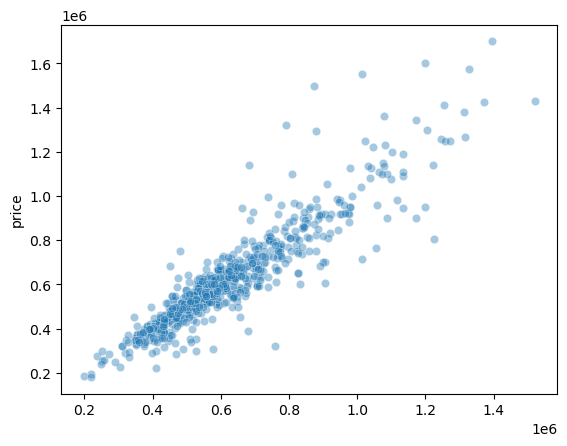

In [17]:
sn.scatterplot(x= pred_c, y= y_test, alpha = .4)
plt.savefig('pred.png', bbox_inches='tight')

<AxesSubplot:ylabel='price'>

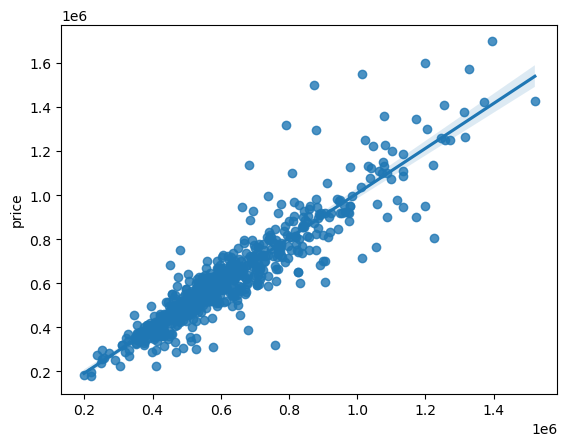

In [20]:
sn.regplot(x= pred_c, y= y_test)

Text(0.5, 1.0, 'Feature Importance')

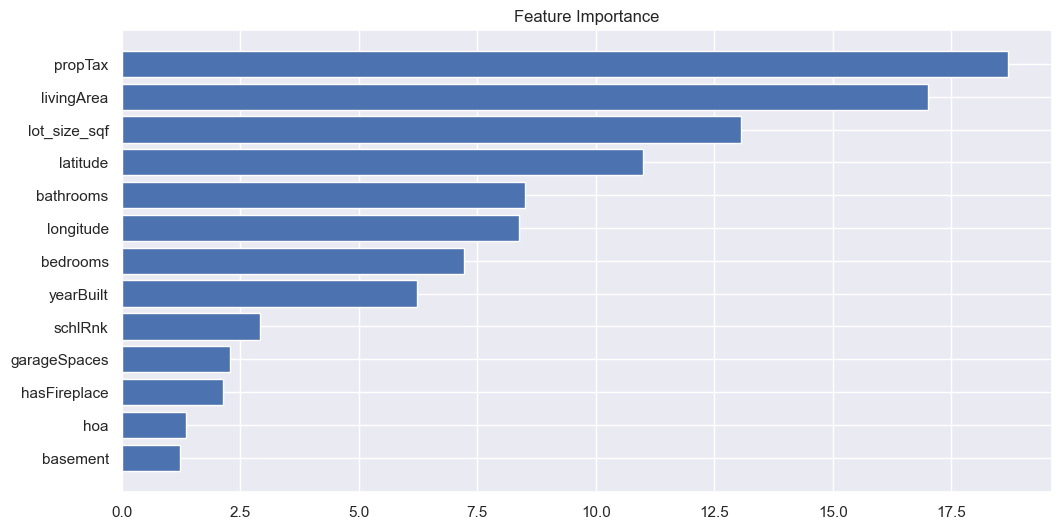

In [222]:
feature_importance = model_c.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [224]:
import shap

In [225]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_c)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

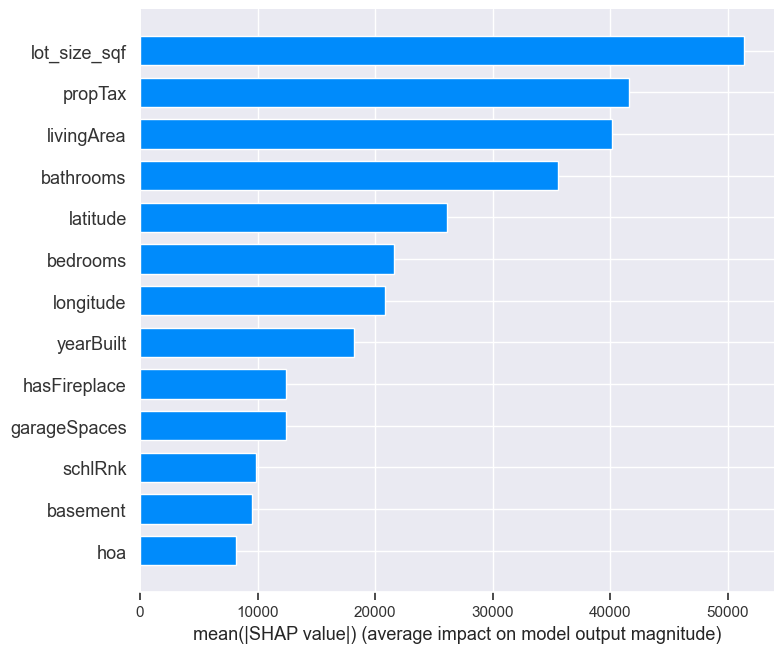

In [227]:
features = X.columns
shap.summary_plot(shap_values, X_train, feature_names=features, plot_type="bar")

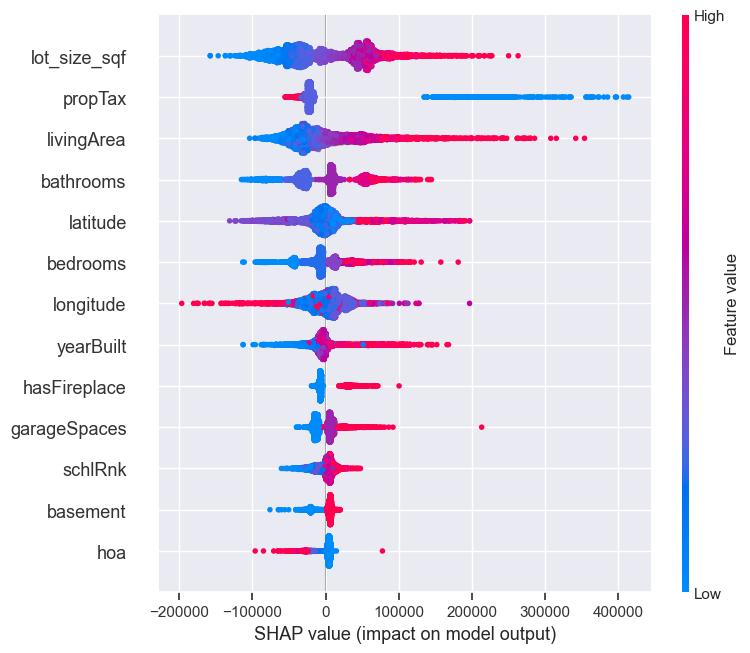

In [228]:
shap.summary_plot(shap_values, X_train, feature_names=features)

# Save the model

In [229]:
import pickle
  
filename = 'finalized_model.sav'
pickle.dump(model_c, open(filename, 'wb'))

In [230]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8374530701713051


## Evaluation Metrics for Regression
 * MAE:Mean Absolute Error
 * MSE : Mean Squared Error 
 * RMSE : Root Mean Squared error
 * R2 score: Coefficient of determination , Goodness of fit
 * Adjusted R2 score
        

# Random Forest 

In [140]:
from sklearn.ensemble import RandomForestRegressor

In [143]:
model3 = RandomForestRegressor(n_estimators= 500, random_state = 5)
model3.fit(X_train2, y_train2)
pred3= model3.predict(X_test2) 
rmse3 = (np.sqrt(mean_squared_error(y_test2, pred3)))
r23 = r2_score(y_test2, pred3)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse3))
print('R2: {:.2f}'.format(r23))

Testing performance
RMSE: 129588.76
R2: 0.75
